In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.optimize import curve_fit
from matplotlib import cm

In [2]:
def moving_average(a, n = 3, start_smooth = 100):
    a_start = a[:start_smooth]
    a_end = a[start_smooth:]
    ret = np.cumsum(a_end, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate((a_start, ret[n - 1:] / n))

In [3]:
def power_law_fit(x, a):
    ''' Use this to fit f^-2 (intermediate f) '''
    return a * x ** (-2)

In [4]:
# Plotting settings:
plt.rc('text', usetex=True)
plt.rc('font', size = 170, weight = 'bold')
plt.rcParams['xtick.major.width'] = 8
plt.rcParams['xtick.major.size'] = 30
plt.rcParams['xtick.labelsize'] = 170
plt.rcParams['ytick.major.width'] = 8
plt.rcParams['ytick.major.size'] = 30
plt.rcParams['ytick.labelsize'] = 170
plt.rc('axes', labelsize=170) 

## SFS

In [76]:
# import data

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
n = 100000
n_wellmixed = 10000
nSFS = 1000
nsim_wellmixed = 1000
tfix = 0

f = np.arange(1, n + 1) / n
f_wellmixed = np.arange(1, n_wellmixed + 1) / n_wellmixed
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

# Find v from lines

freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)


SFS = np.loadtxt(
    'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))


SFS_well_mixed = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n_wellmixed, nsim_wellmixed))
SFS_well_mixed2 = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n, 20))

f_wellmixed_combined = np.append(f[:78], f_wellmixed[8:])
SFS_wellmixed_combined = np.append(SFS_well_mixed2[:78], SFS_well_mixed[8:])

In [77]:
# smooth curves

smooth_SFS_wellmixed_combined = moving_average(SFS_wellmixed_combined, navg, start_smooth)
smooth_SFS = moving_average(SFS, navg, start_smooth)

## Overall allele frequency spectra

C:\Users\jim903\Anaconda3\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
C:\Users\jim903\Anaconda3\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line1), but could not find a label for it.
  warnings.warn(


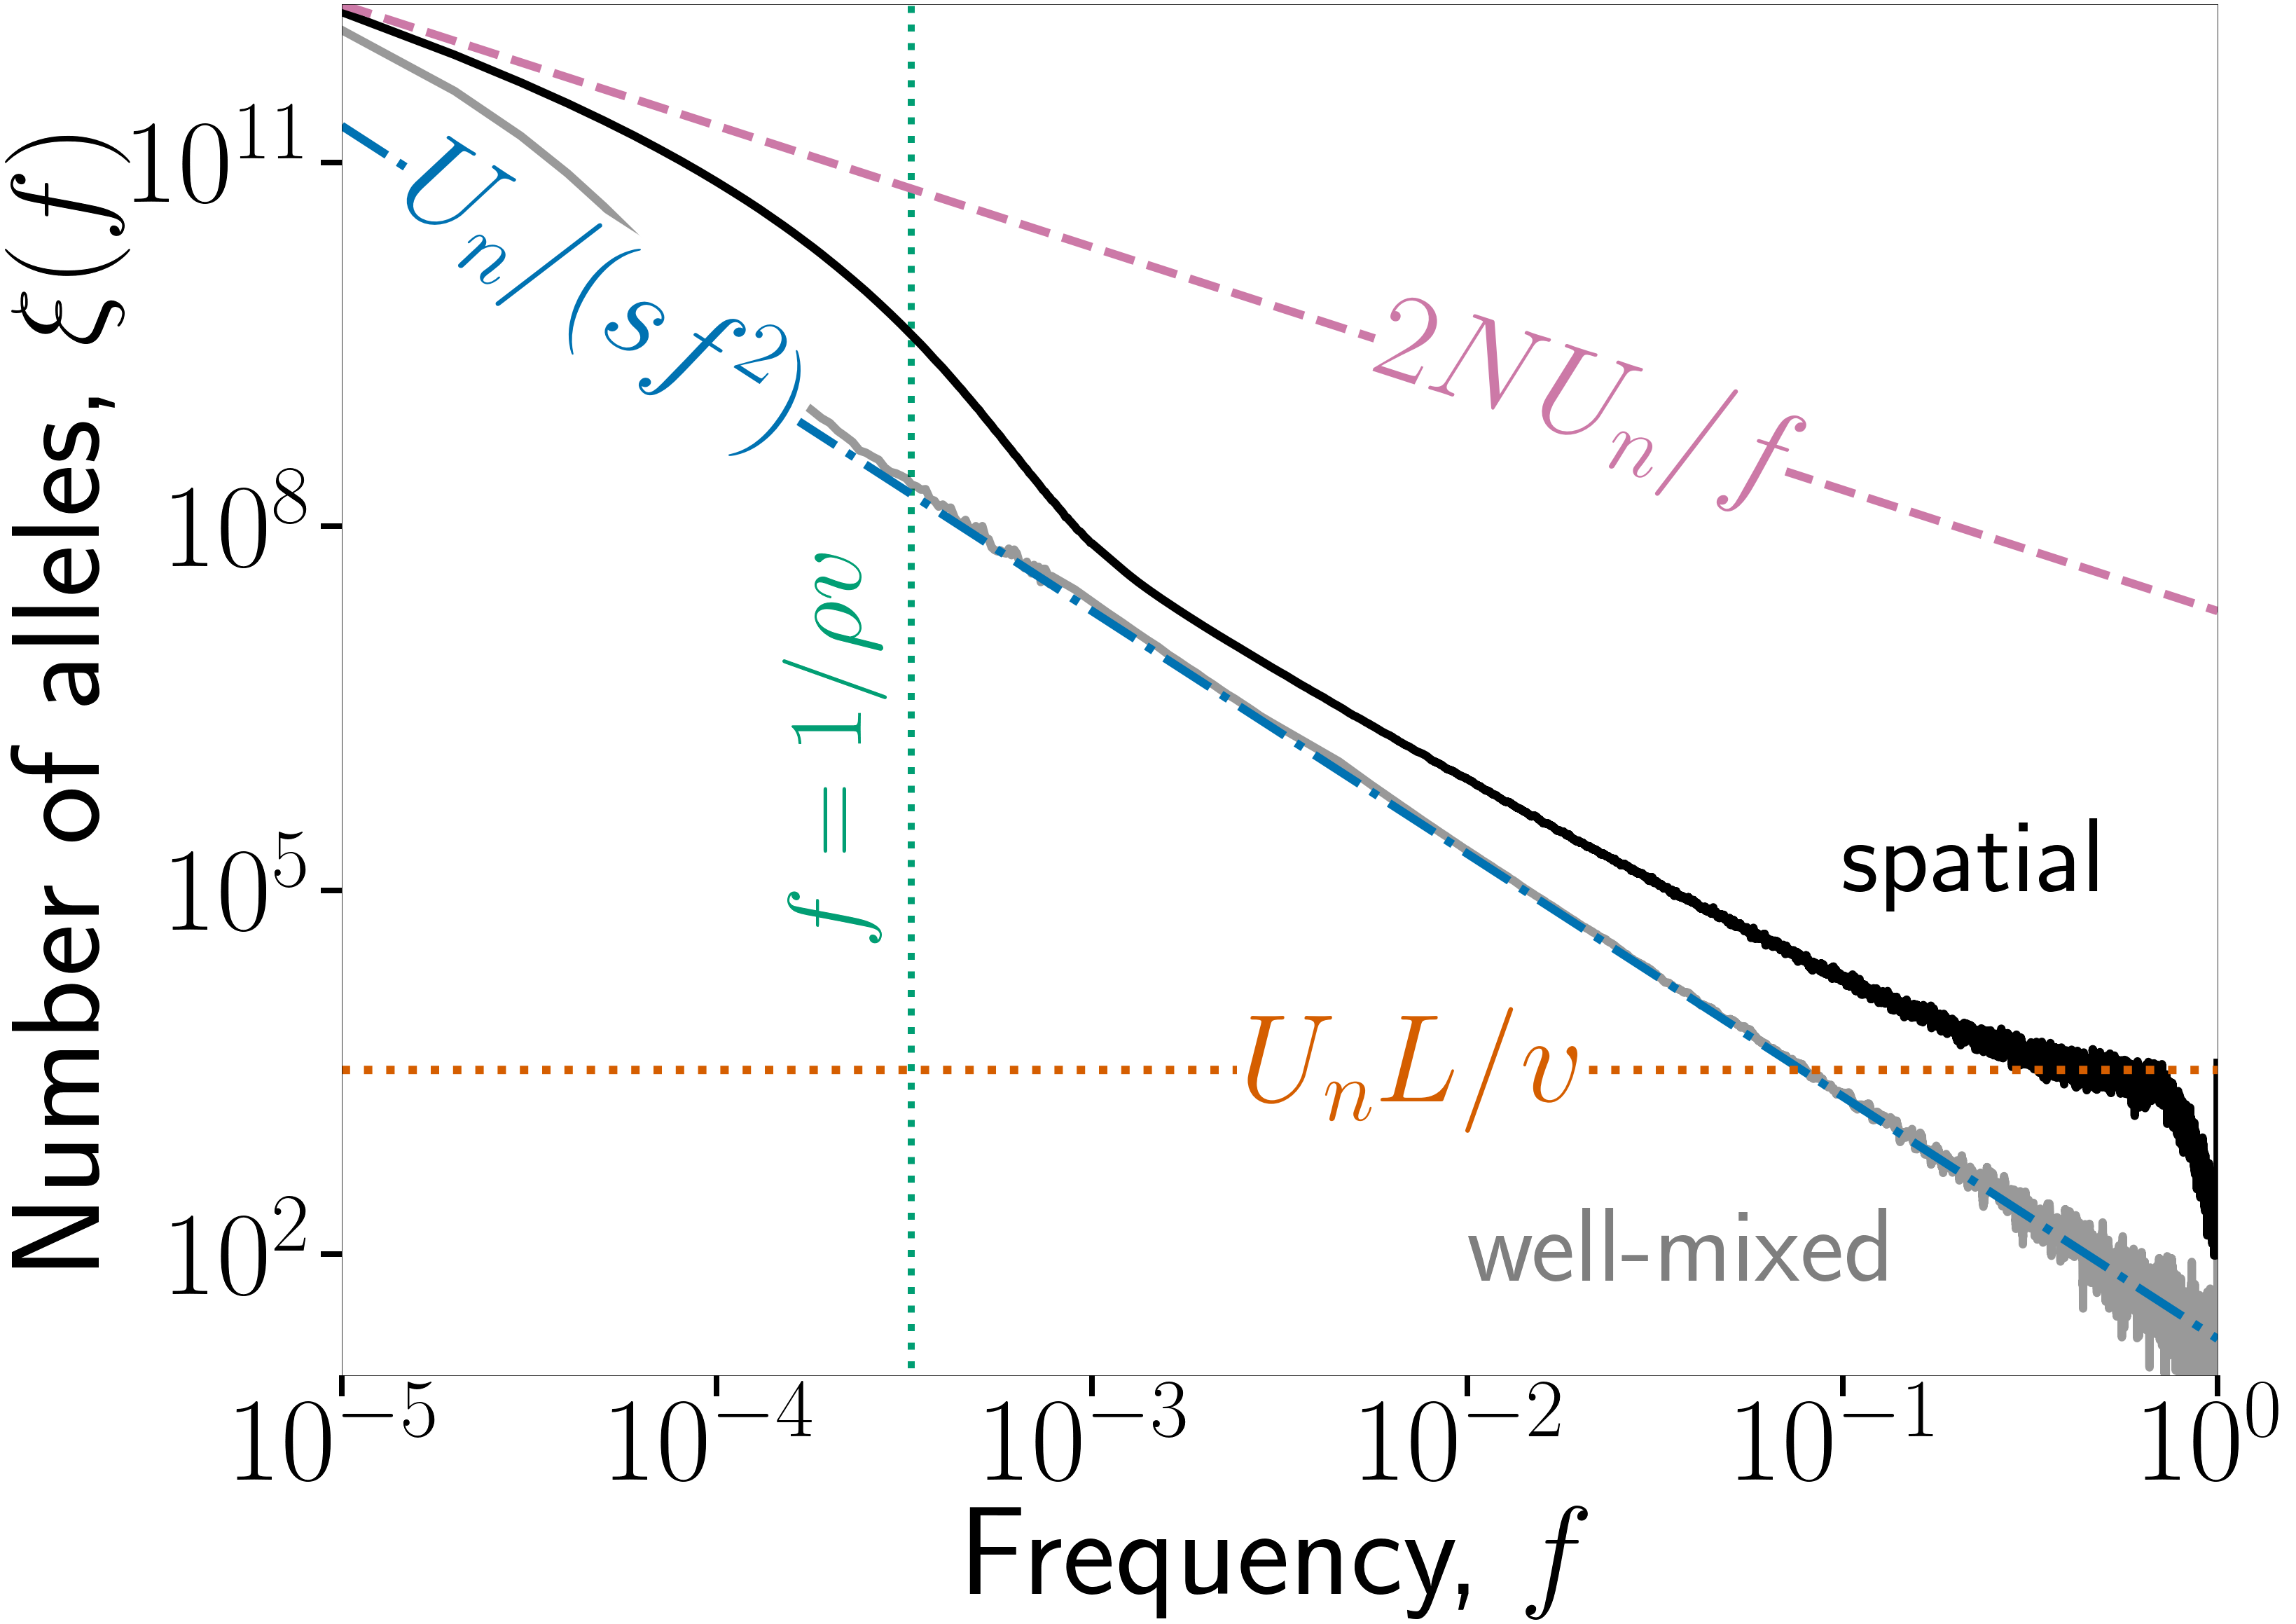

In [78]:
# plot the figure on a loglog scale

fig, ax = plt.subplots(figsize = (48,36))
ax.set_xlabel(r'Frequency, $f$', fontsize = 180)
ax.set_ylabel(r'Number of alleles, $\xi(f)$', fontsize = 180)

ax.vlines(1 / (rho * v), 10 ** (-2), 10 ** 15, linestyle = 'dotted', linewidth = 10, color = '#009e73')
ax.text(1.5e-4, 6e4, r'$f = 1 / \rho v$', color = '#009e73', fontsize = 150, rotation = 90, 
         backgroundcolor = 'w')

#plt.text(0.002, 3 * 10 ** 5, r'$U_n \ln( N s f) / (s f^2)$', color = '#0072b2', fontsize = 150, rotation = -25)
#        
ax.loglog(moving_average(f_wellmixed_combined, navg, start_smooth), smooth_SFS_wellmixed_combined, 
             linewidth = 12, color = 'k', alpha = 0.4)
ax.text(10 ** (-2), 60, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 150, backgroundcolor = 'w')

ax.loglog(f_short, smooth_SFS, linewidth = 12, color = 'k')
ax.text(10 ** (-1), 10 ** 5, 'spatial', color = 'k', fontsize = 150, backgroundcolor = 'w')

neutral, = ax.loglog(f_short, 2 * Un * rho * L * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '--', linewidth = 12, color = '#cc79a7')


bsc, = ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', linewidth = 12, color = '#0072b2', 
           label = r'$U_n / (sf^2)$')


flat, = ax.semilogy(f_short, np.ones(len(f_short)) * L / v, linewidth = 12, linestyle = 'dotted',
              label = r'$U_n L / v$', color = '#d55e00')

ax.set_ylim((10, 2 * 10 ** 12))
ax.set_xlim((1e-5, 1))

plt.xticks(np.logspace(-5,0,6))
plt.yticks(np.logspace(2,11,4))

xvals = [0.02, 0.00005, 0.007]
labelLines(ax.get_lines(), xvals = xvals, fontsize = 180, backgroundcolor = 'w');

In [8]:
# save the figure

fig.savefig('asex_log.pdf', format = 'pdf', bbox_inches = 'tight')

 ## Allele frequency spectra just in the surfing range

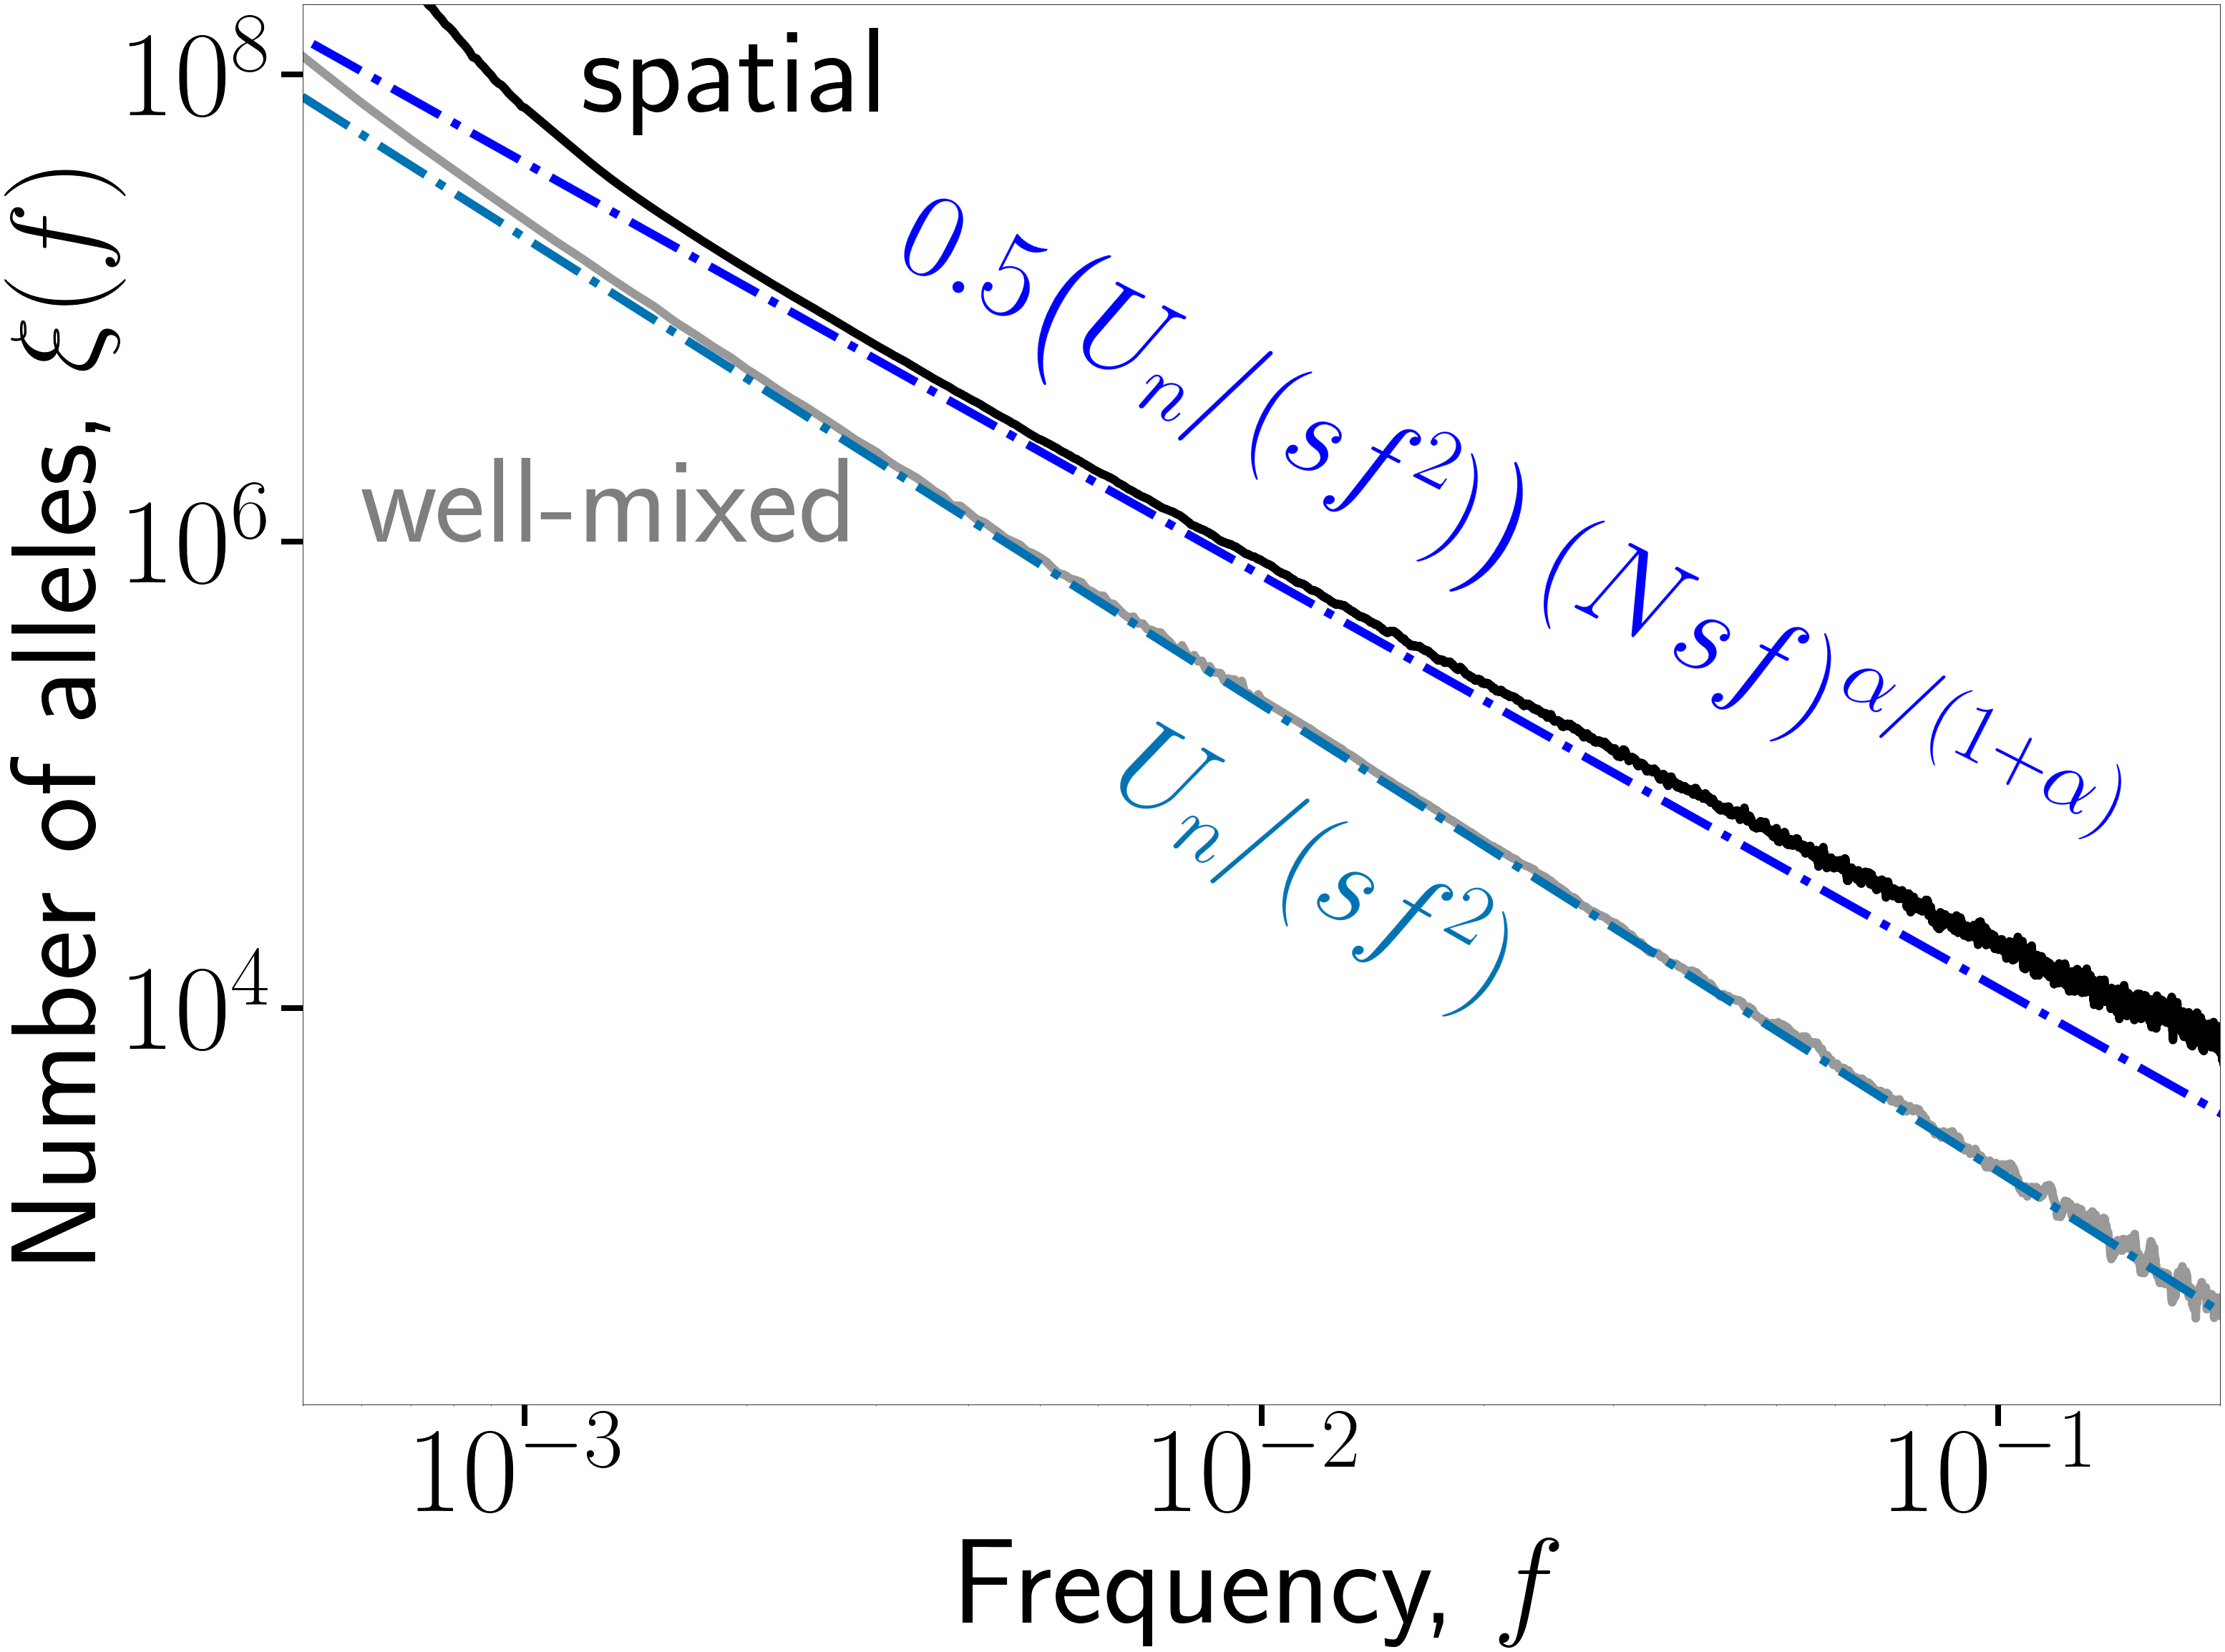

In [79]:
# plt.rc('font', family='serif', size = 150, weight = 'bold')
fig, ax = plt.subplots(figsize = (48, 36))
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')

ax.loglog(moving_average(f_wellmixed, navg, start_smooth), moving_average(SFS_well_mixed, navg, start_smooth), 
             linewidth = 12, color = 'k', alpha = 0.4)

ax.loglog(f_short, moving_average(SFS, navg, start_smooth), linewidth = 12, color = 'k')

ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', linewidth = 12, color = '#0072b2', label = r'$U_n / (sf^2)$')
# bsc2, = ax.loglog(f_short, Un * np.log(N * s * f_short)**3 * np.sqrt(m) / s**(3 / 2) / f_short**2 / L , 
#            linestyle = '-.', linewidth = 12, color = 'b', label = r'$\boldmath{U_n \ln(Nsf)^3 \sqrt{m} / (L s^{3/2} f^2)}$')

alpha = 0.30
prefactor = 0.5
ax.loglog(f_short, prefactor * Un * ((rho * L)**alpha / s / f_short**(2 + alpha))**(1 / (1 + alpha)),
          linestyle = '-.', linewidth = 12, color = 'b')

ax.text(1.2e-3, 7e7, 'spatial', color = 'k', fontsize = 170)
ax.text(6e-4, 1e6, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 170)
ax.text(3e-3, 4e4, '${}$'.format(prefactor) + r'$\left(U_n / (s f^2)\right) (N s f)^{\alpha / (1 + \alpha)}$',  
         color = 'b', fontsize = 170, rotation=-27)
ax.text(6e-3, 1e4, r'$U_n/(s f^2)$', color = '#0072b2', fontsize = 170, rotation=-30)

ax.set_xlim((5 * 10 ** -4, 2 * 10 ** -1))
ax.set_ylim((200, 2 * 10 ** 8));

In [80]:
# save the figure
fig.savefig('Figure3a.pdf', format = 'pdf', bbox_inches = 'tight')

# Showing the collapse of different parameter combinations for surfing SFS

In [81]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size = 60, weight = 'bold')
Un = 1
r = 0
n_forward = 100
tfix = 0

n = 100000
nSFS = 1000

blue_cmap = cm.get_cmap('Blues')
red_cmap = cm.get_cmap('Reds')
grey_cmap = cm.get_cmap('Greys')
viridis_cmap = cm.get_cmap('viridis')

slist = np.arange(0.02, 0.07, 0.01)
mlist = np.arange(0.2, 0.55, 0.05)
Lrholist = [[500, 2000], [500, 20000], [1000, 10000], [1000, 1000], [2000, 5000], [5000, 2000]]
tfinallist = [10000, 1000000, 100000, 100000, 100000, 100000, 100000]

f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)

In [82]:
# Define a scaling factor here. 

def scale(L, rho, s, m, f, alpha=0.33):
    ''' scaling factor to collapse surfing SFSs.'''
    return(s / (L * rho * s)**(alpha / (1 + alpha)))

scale_label = r'$\xi(f) / \left[(U_n /s) (N s)^\frac{\alpha}{1 + \alpha}\right]$'

In [83]:
# import data for varying s

m = 0.25
L = 500
rho = 20000
N = rho * L
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for s in slist]
svar_smooth_SFS = [moving_average(np.loadtxt(filenames[sind]), navg, start_smooth) for sind, s in enumerate(slist)]

svar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for s in slist]

svar_scaling = [scale(L, rho, s, m, f_short) for s in slist] 

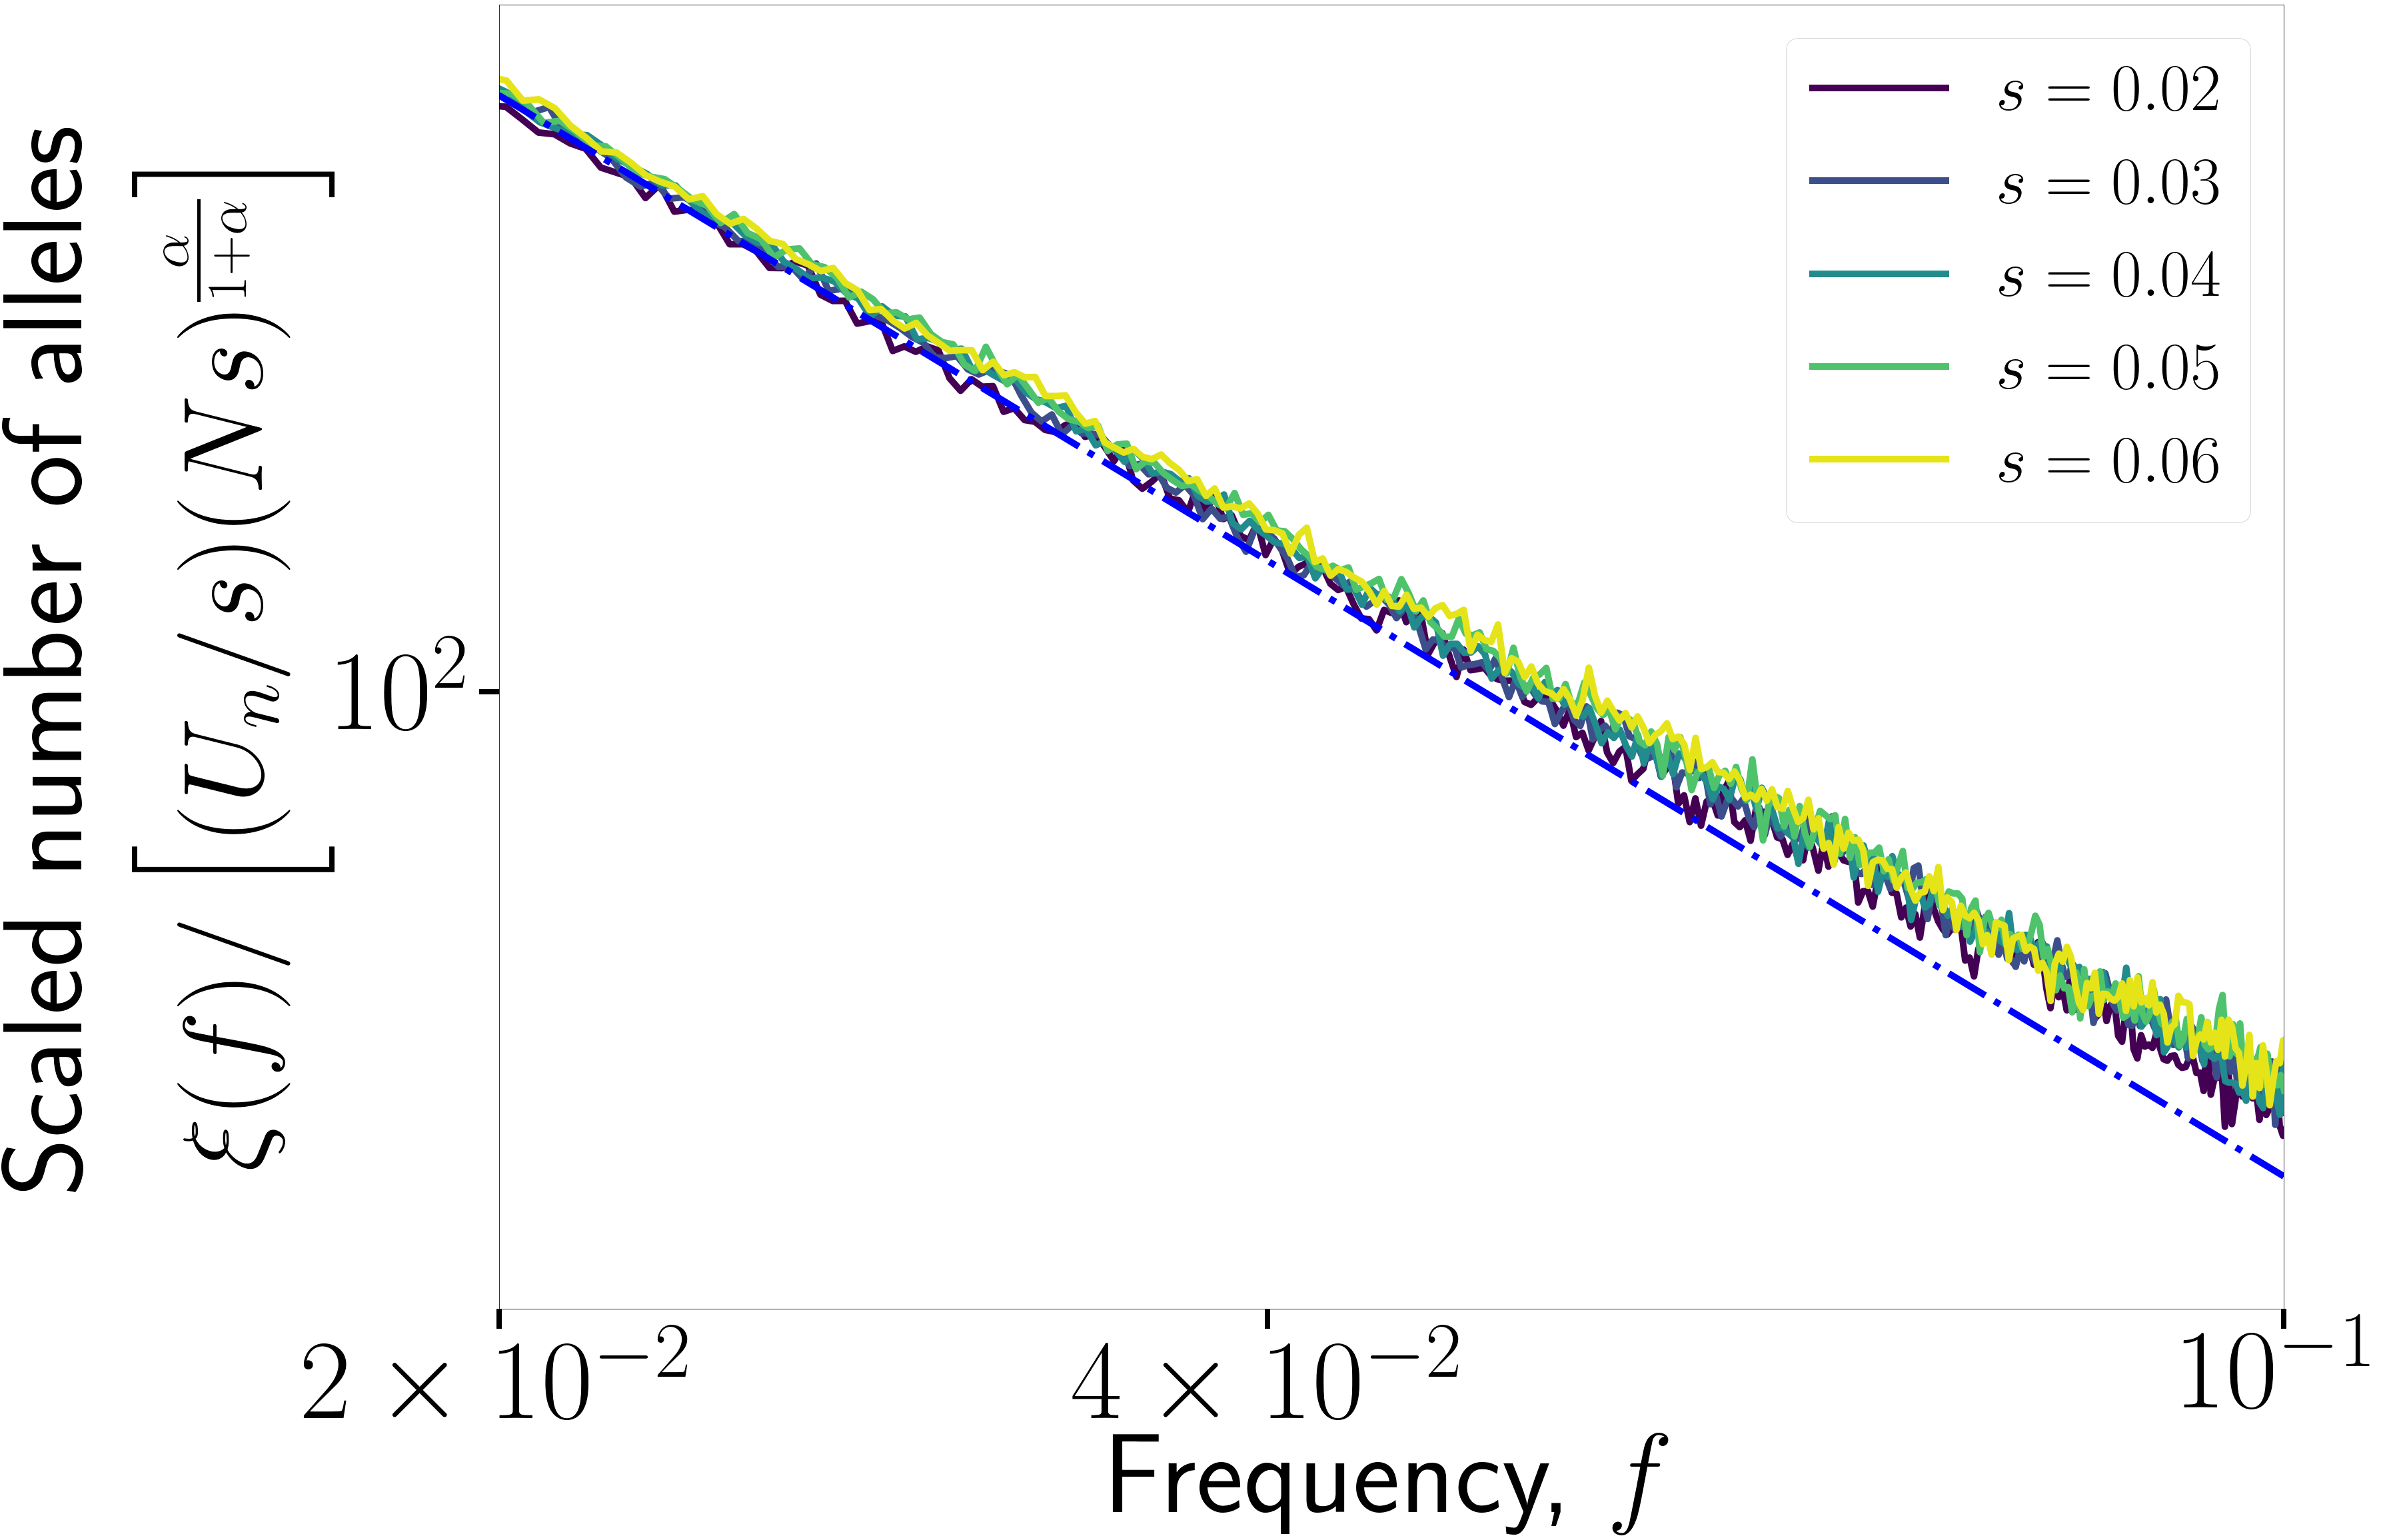

In [84]:
# plot just the varying s:

prefactor = 0.5
alpha = 0.33

fig, ax = plt.subplots(figsize = (48, 36));
for i, sfs in enumerate(svar_smooth_SFS):
    ax.plot(f_short[svar_fstart_ind[i]::30], 
            sfs[svar_fstart_ind[i]::30] * svar_scaling[i], 
             label=r'$s = {:.2f}$'.format(slist[i]), color = viridis_cmap(0.24 * i), lw=10)
plt.legend(fontsize=100)    
ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', lw=10, c='b', 
       label =r'$0.5 f^{- (\alpha + 2) / (\alpha + 1)}$')

ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 600))
plt.xticks((2e-2, 4e-2, 1e-1))
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+ scale_label)
plt.minorticks_off()


In [85]:
# save figure:
fig.savefig('vary_s.pdf', format = 'pdf', bbox_inches = 'tight')

In [86]:
# import data for varying m

s = 0.05
L = 500
rho = 20000
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for m in mlist]
mvar_smooth_SFS = [moving_average(np.loadtxt(filenames[mind]), navg, start_smooth) for mind, m in enumerate(mlist)]

mvar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for m in mlist]

mvar_scaling = [scale(L, rho, s, m, f_short) for m in mlist]


Text(0, 0.5, 'Scaled number of alleles\n$\\xi(f) / \\left[(U_n /s) (N s)^\\frac{\\alpha}{1 + \\alpha}\\right]$')

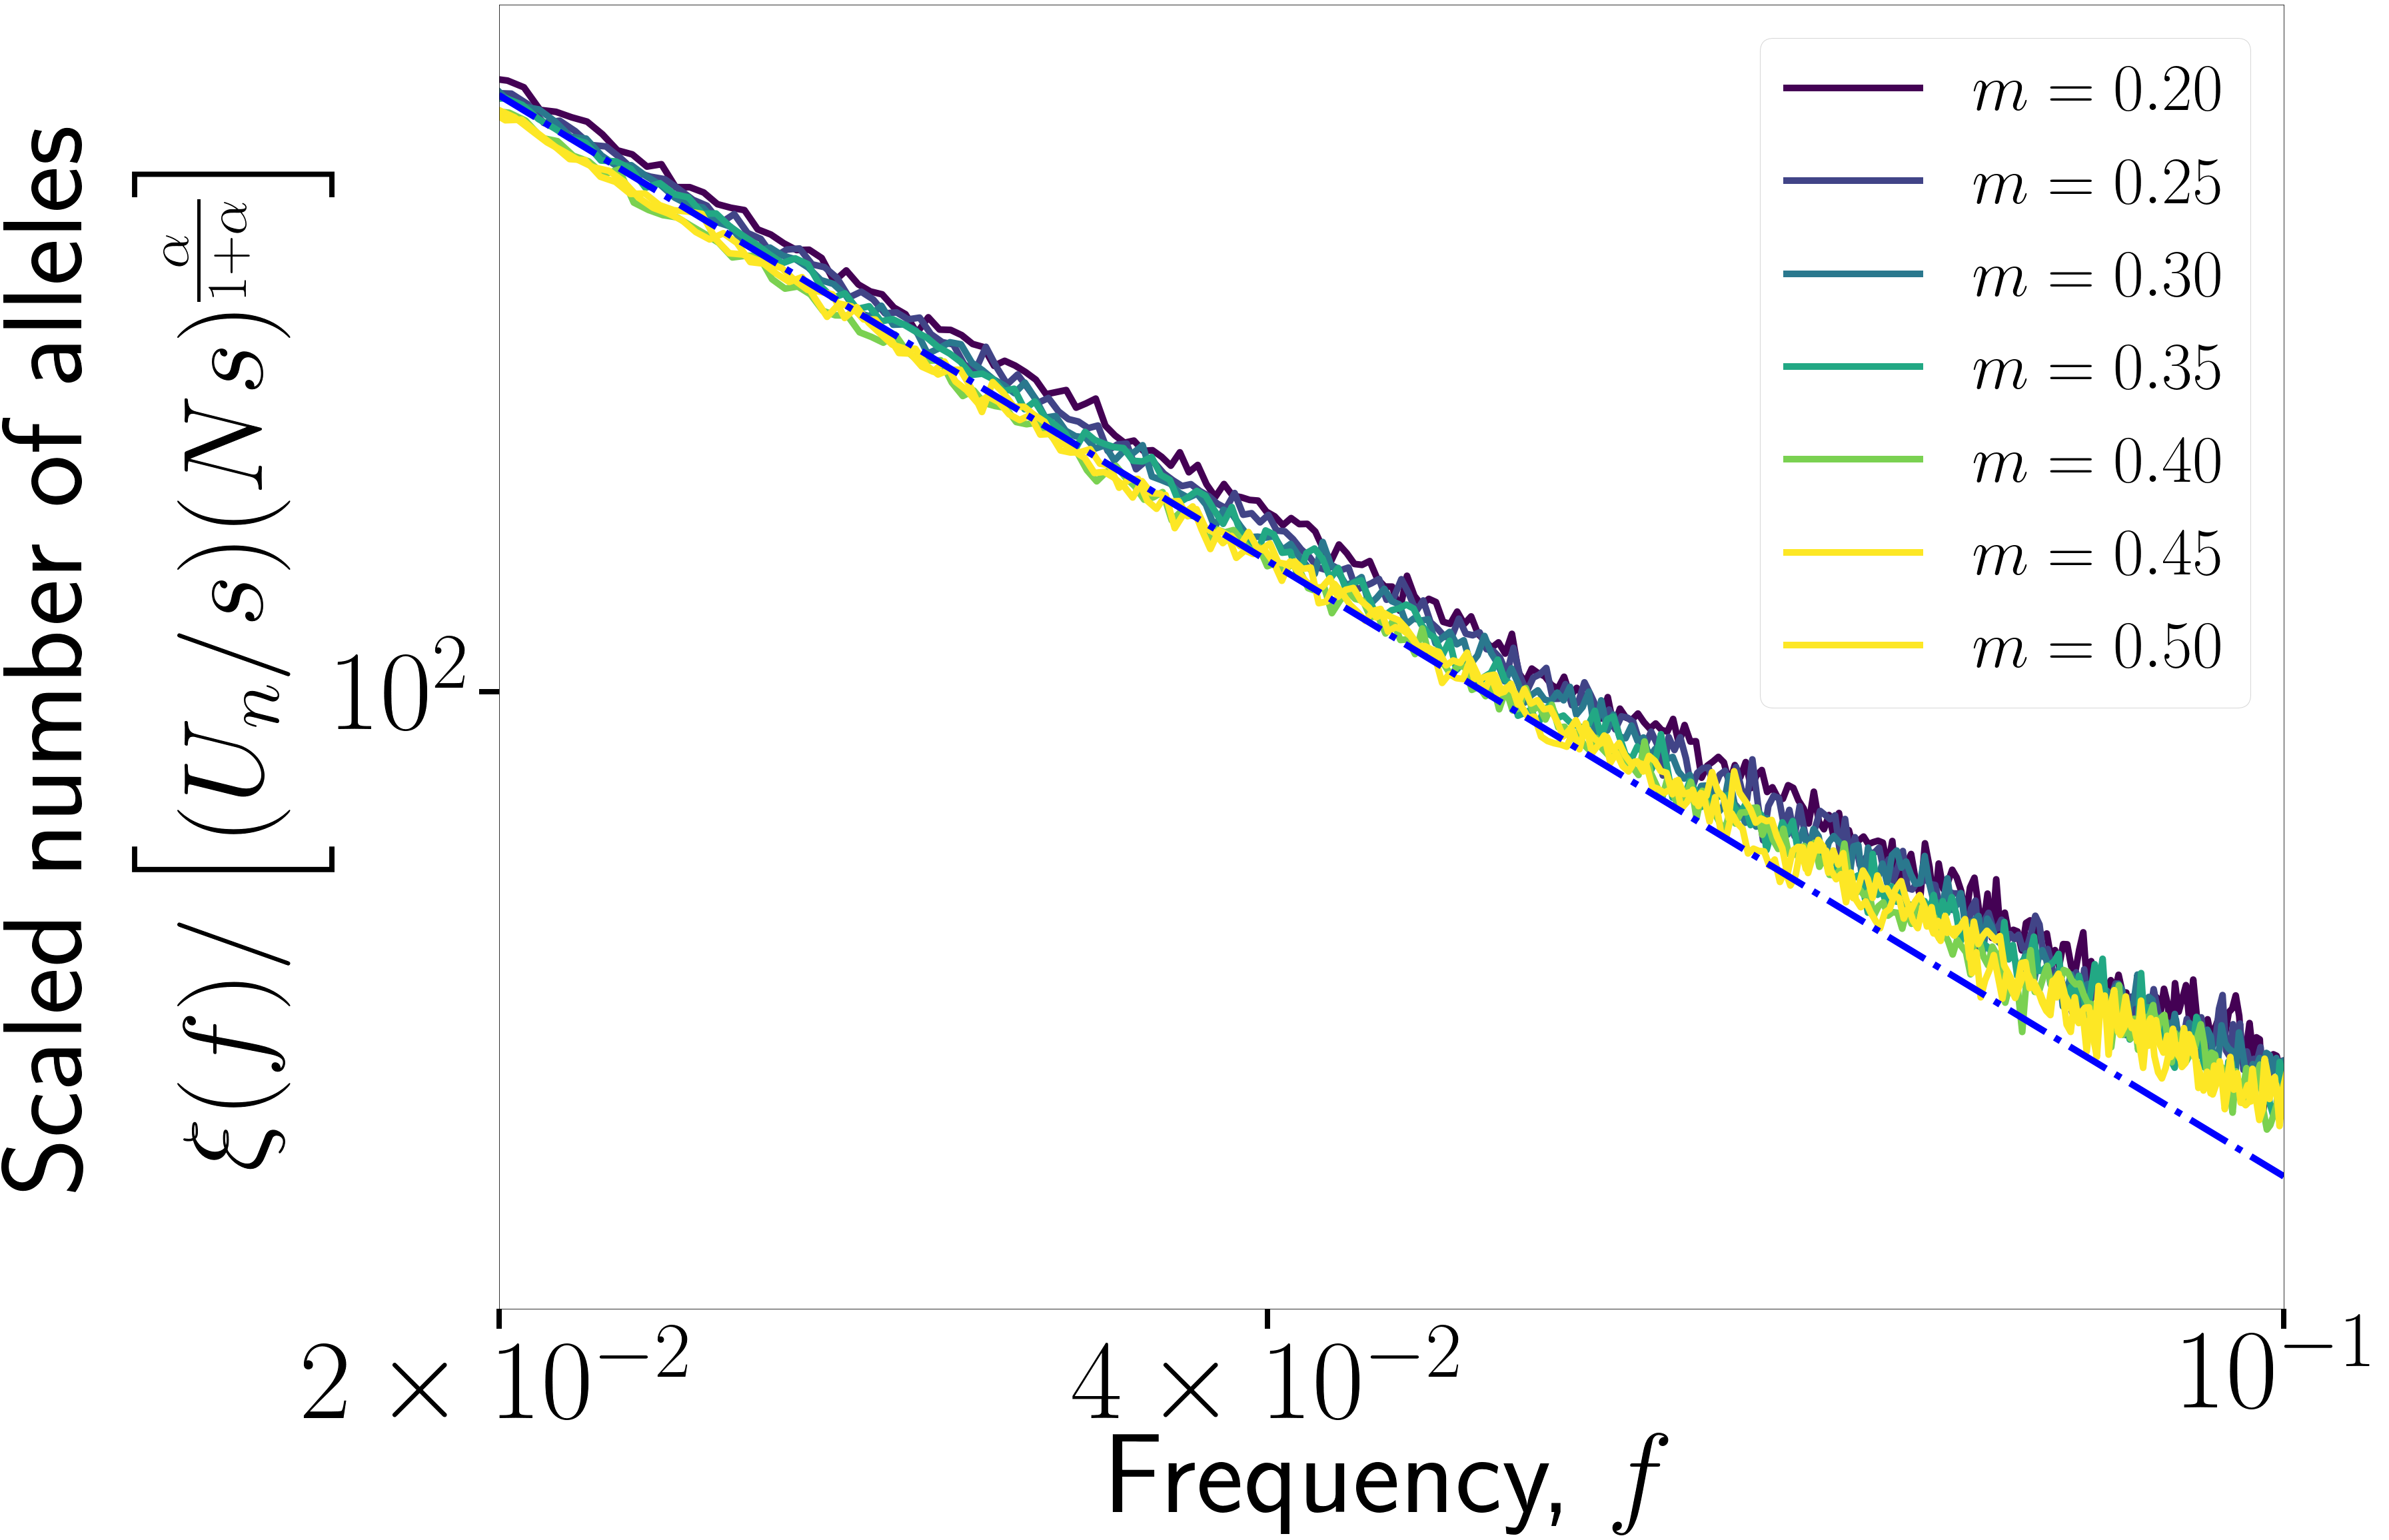

In [87]:

fig, ax = plt.subplots(figsize = (48, 36));
for i, sfs in enumerate(mvar_smooth_SFS):
    ax.plot(f_short[mvar_fstart_ind[i]::30], 
            sfs[mvar_fstart_ind[i]::30] * mvar_scaling[i], 
            label=r'$m = {:.2f}$'.format(mlist[i]), color = viridis_cmap(i * 0.2), lw=10)
plt.legend(fontsize=100)    

ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', lw=10, c='b')


ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 600))
plt.xticks((2e-2, 4e-2, 1e-1))
plt.minorticks_off()
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+ scale_label) 

In [88]:
# save figure:
fig.savefig('vary_m.pdf', format = 'pdf', bbox_inches = 'tight')

In [89]:
# import data for varying L and rho

s = 0.05
m = 0.25

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(Lrho[0], 
                 Lrho[1], s, m, r, tfinallist[ind], n, tfix, nSFS) for ind, Lrho in enumerate(Lrholist)]
Lrhovar_smooth_SFS = [moving_average(np.loadtxt(filenames[ind]), navg, start_smooth) for ind, Lrho in enumerate(Lrholist)]

Lrhovar_fstart_ind = [int(10 / (Lrho[1] * np.sqrt(m * s)) * n) for Lrho in Lrholist]

Lrhovar_lines = []

Lrhovar_marker = []
for Lrho in Lrholist:
    N = Lrho[0] * Lrho[1]
    if int(N) == int(10 ** 5):
        Lrhovar_marker.append('o')
    elif int(N) == int(10 ** 6):
        Lrhovar_marker.append('x')
    elif int(N) == int(10 ** 7):
        Lrhovar_marker.append('v')
    

Text(0, 0.5, 'Scaled number of alleles\n$\\xi(f) / \\left[(U_n /s) (N s)^\\frac{\\alpha}{1 + \\alpha}\\right]$')

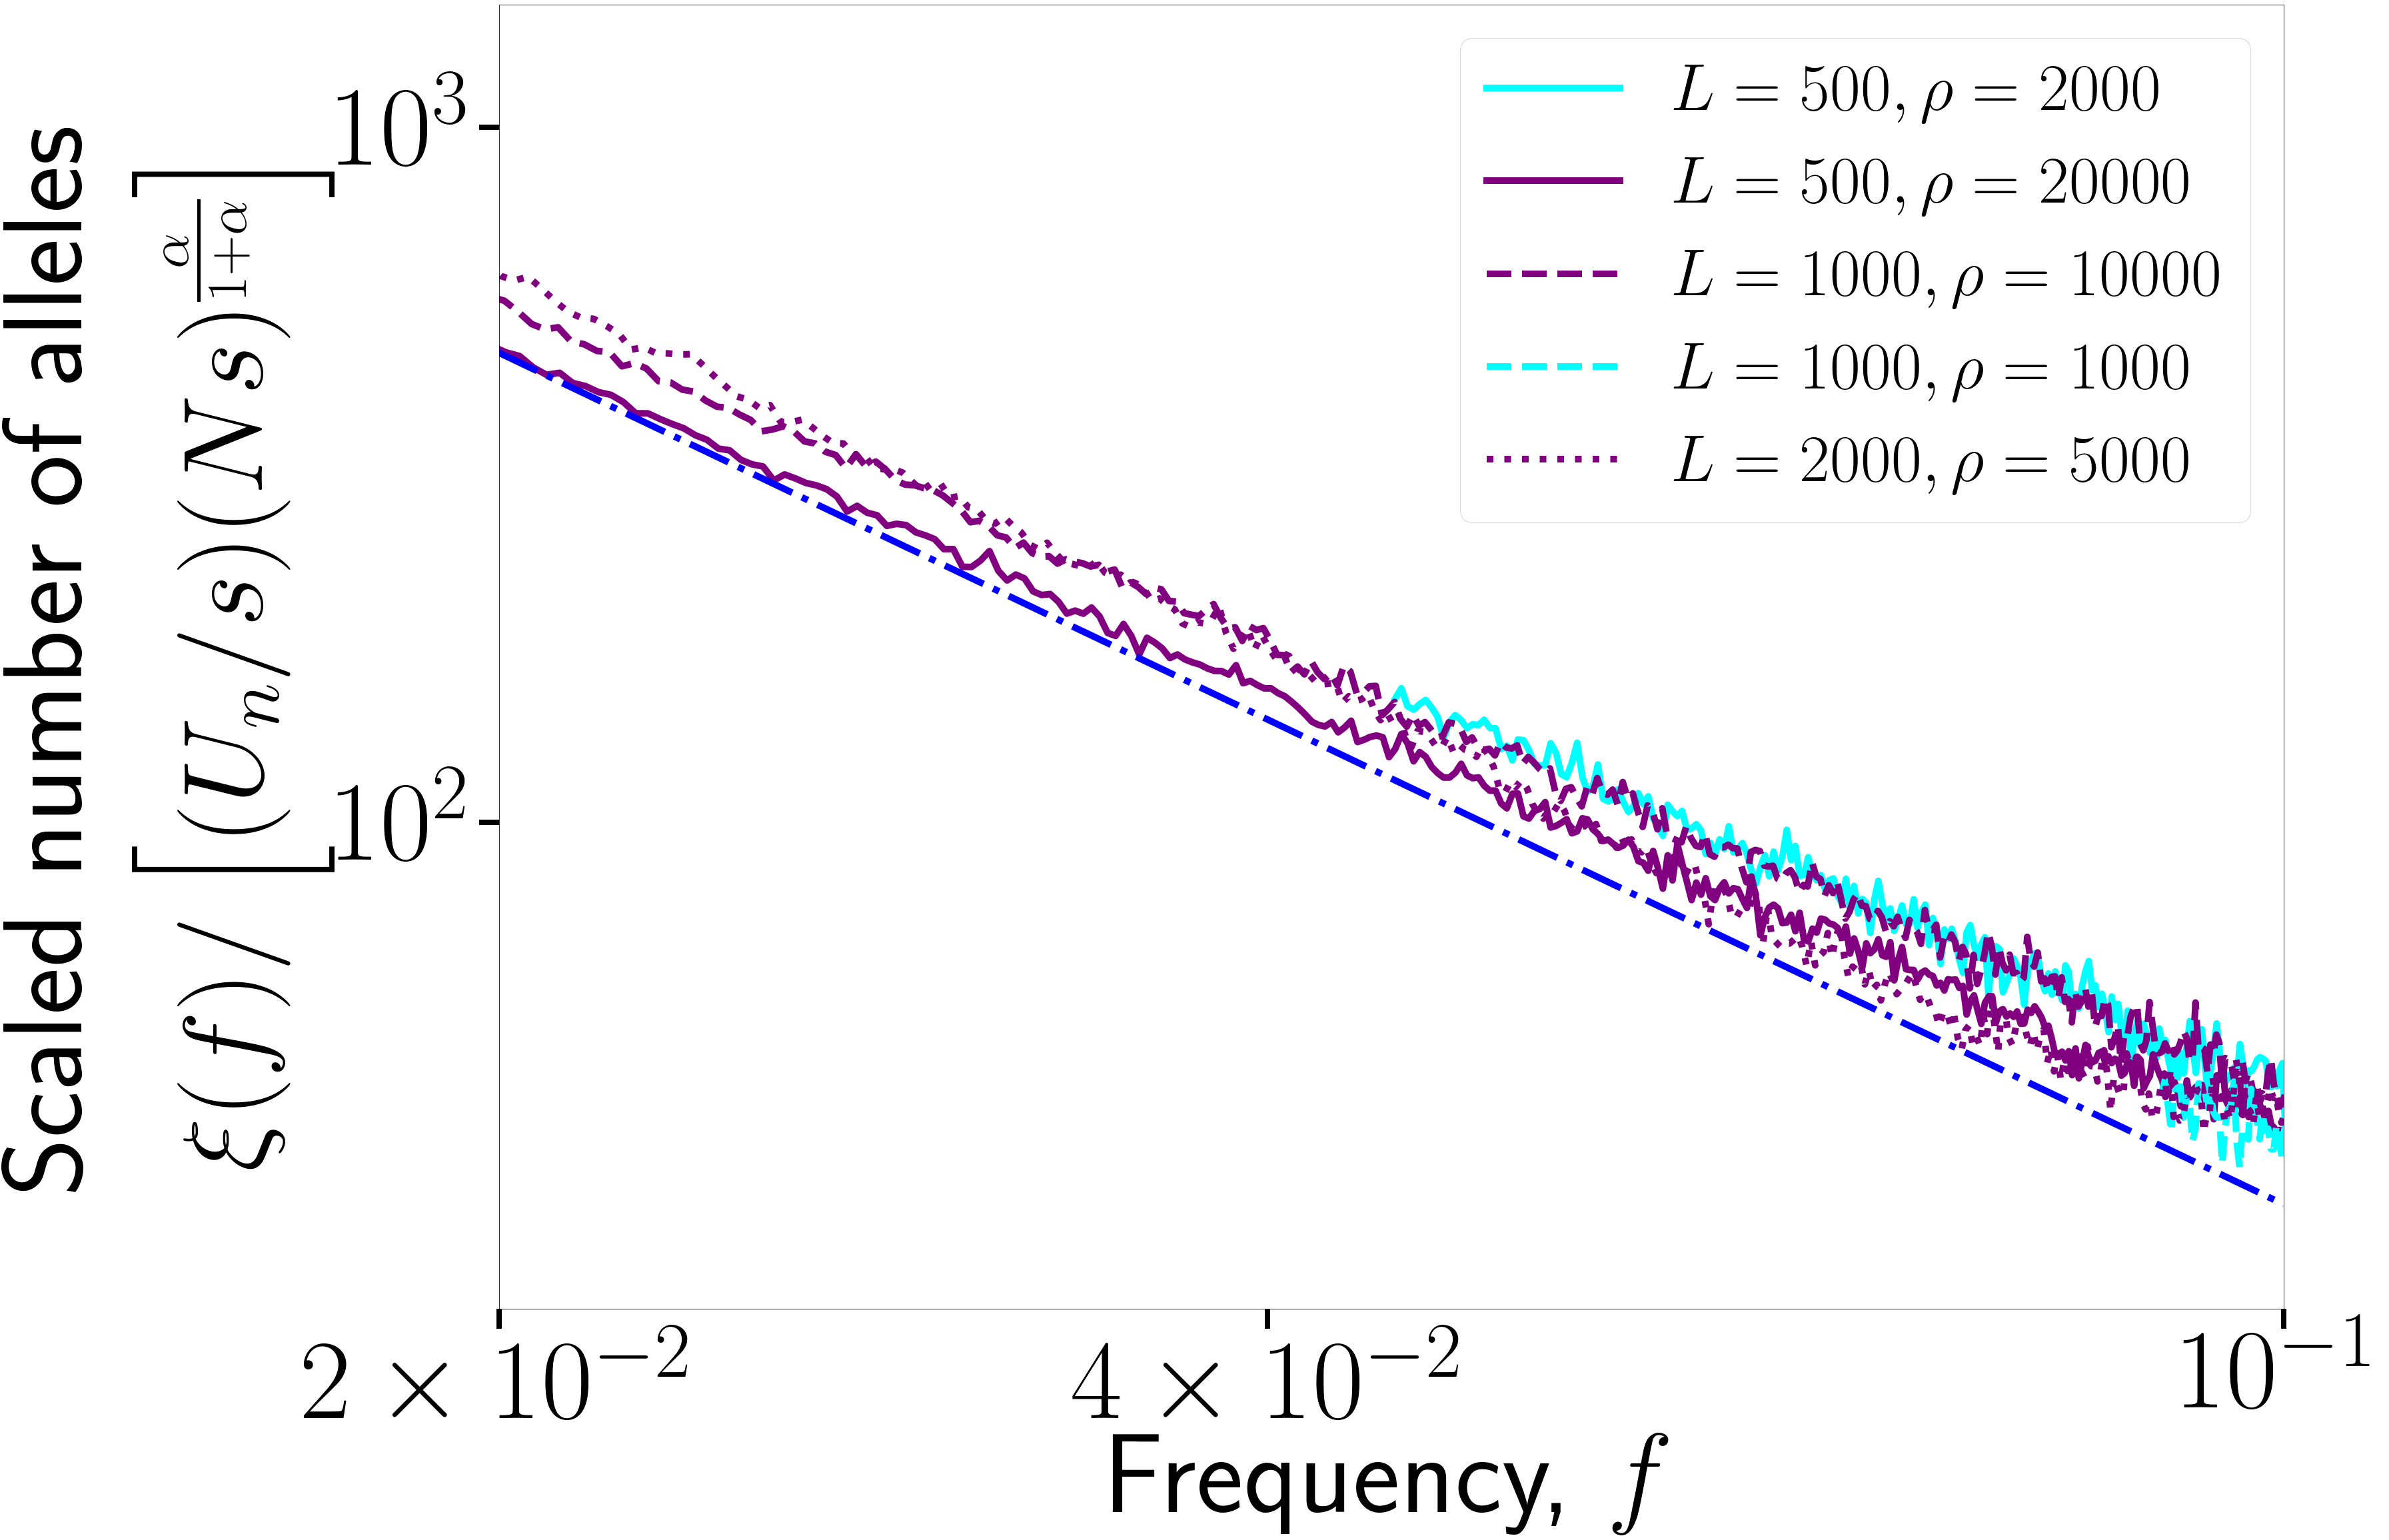

In [90]:
# plot just the varying L and rho:

def Lrhovar_line(L):
    if L==2000:
        return ':'
    if L==1000:
        return '--'
    if L == 500:
        return '-'
    
def Lrho_var_color(Lrho):
    N = Lrho[0] * Lrho[1]
    if N == 1e6:
        return 'cyan'
    if N == 1e7:
        return 'purple'

fig, ax = plt.subplots(figsize = (48, 36));

Lrhovar_scaling = [scale(Lrho[0], Lrho[1], s, m, f_short, 0.33) for Lrho in Lrholist] 

for i, sfs in enumerate(Lrhovar_smooth_SFS[:-1]):
    ax.plot(f_short[Lrhovar_fstart_ind[i]::25], 
            sfs[Lrhovar_fstart_ind[i]::25] * Lrhovar_scaling[i], Lrhovar_line(Lrholist[i][0]),
    label=r'$L={}, \rho={}$'.format(Lrholist[i][0], Lrholist[i][1]), lw=10, 
            color = Lrho_var_color(Lrholist[i]))
plt.legend(fontsize=100)    

ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', lw=10, c='b')


ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 1500))
plt.xticks((2e-2, 4e-2, 1e-1))
plt.minorticks_off()
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+scale_label)


In [91]:
# save figure:
fig.savefig('vary_Lrho.pdf', format = 'pdf', bbox_inches = 'tight')

### Uniform tail

C:\Users\jim903\Anaconda3\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(


(1e-05, 1)

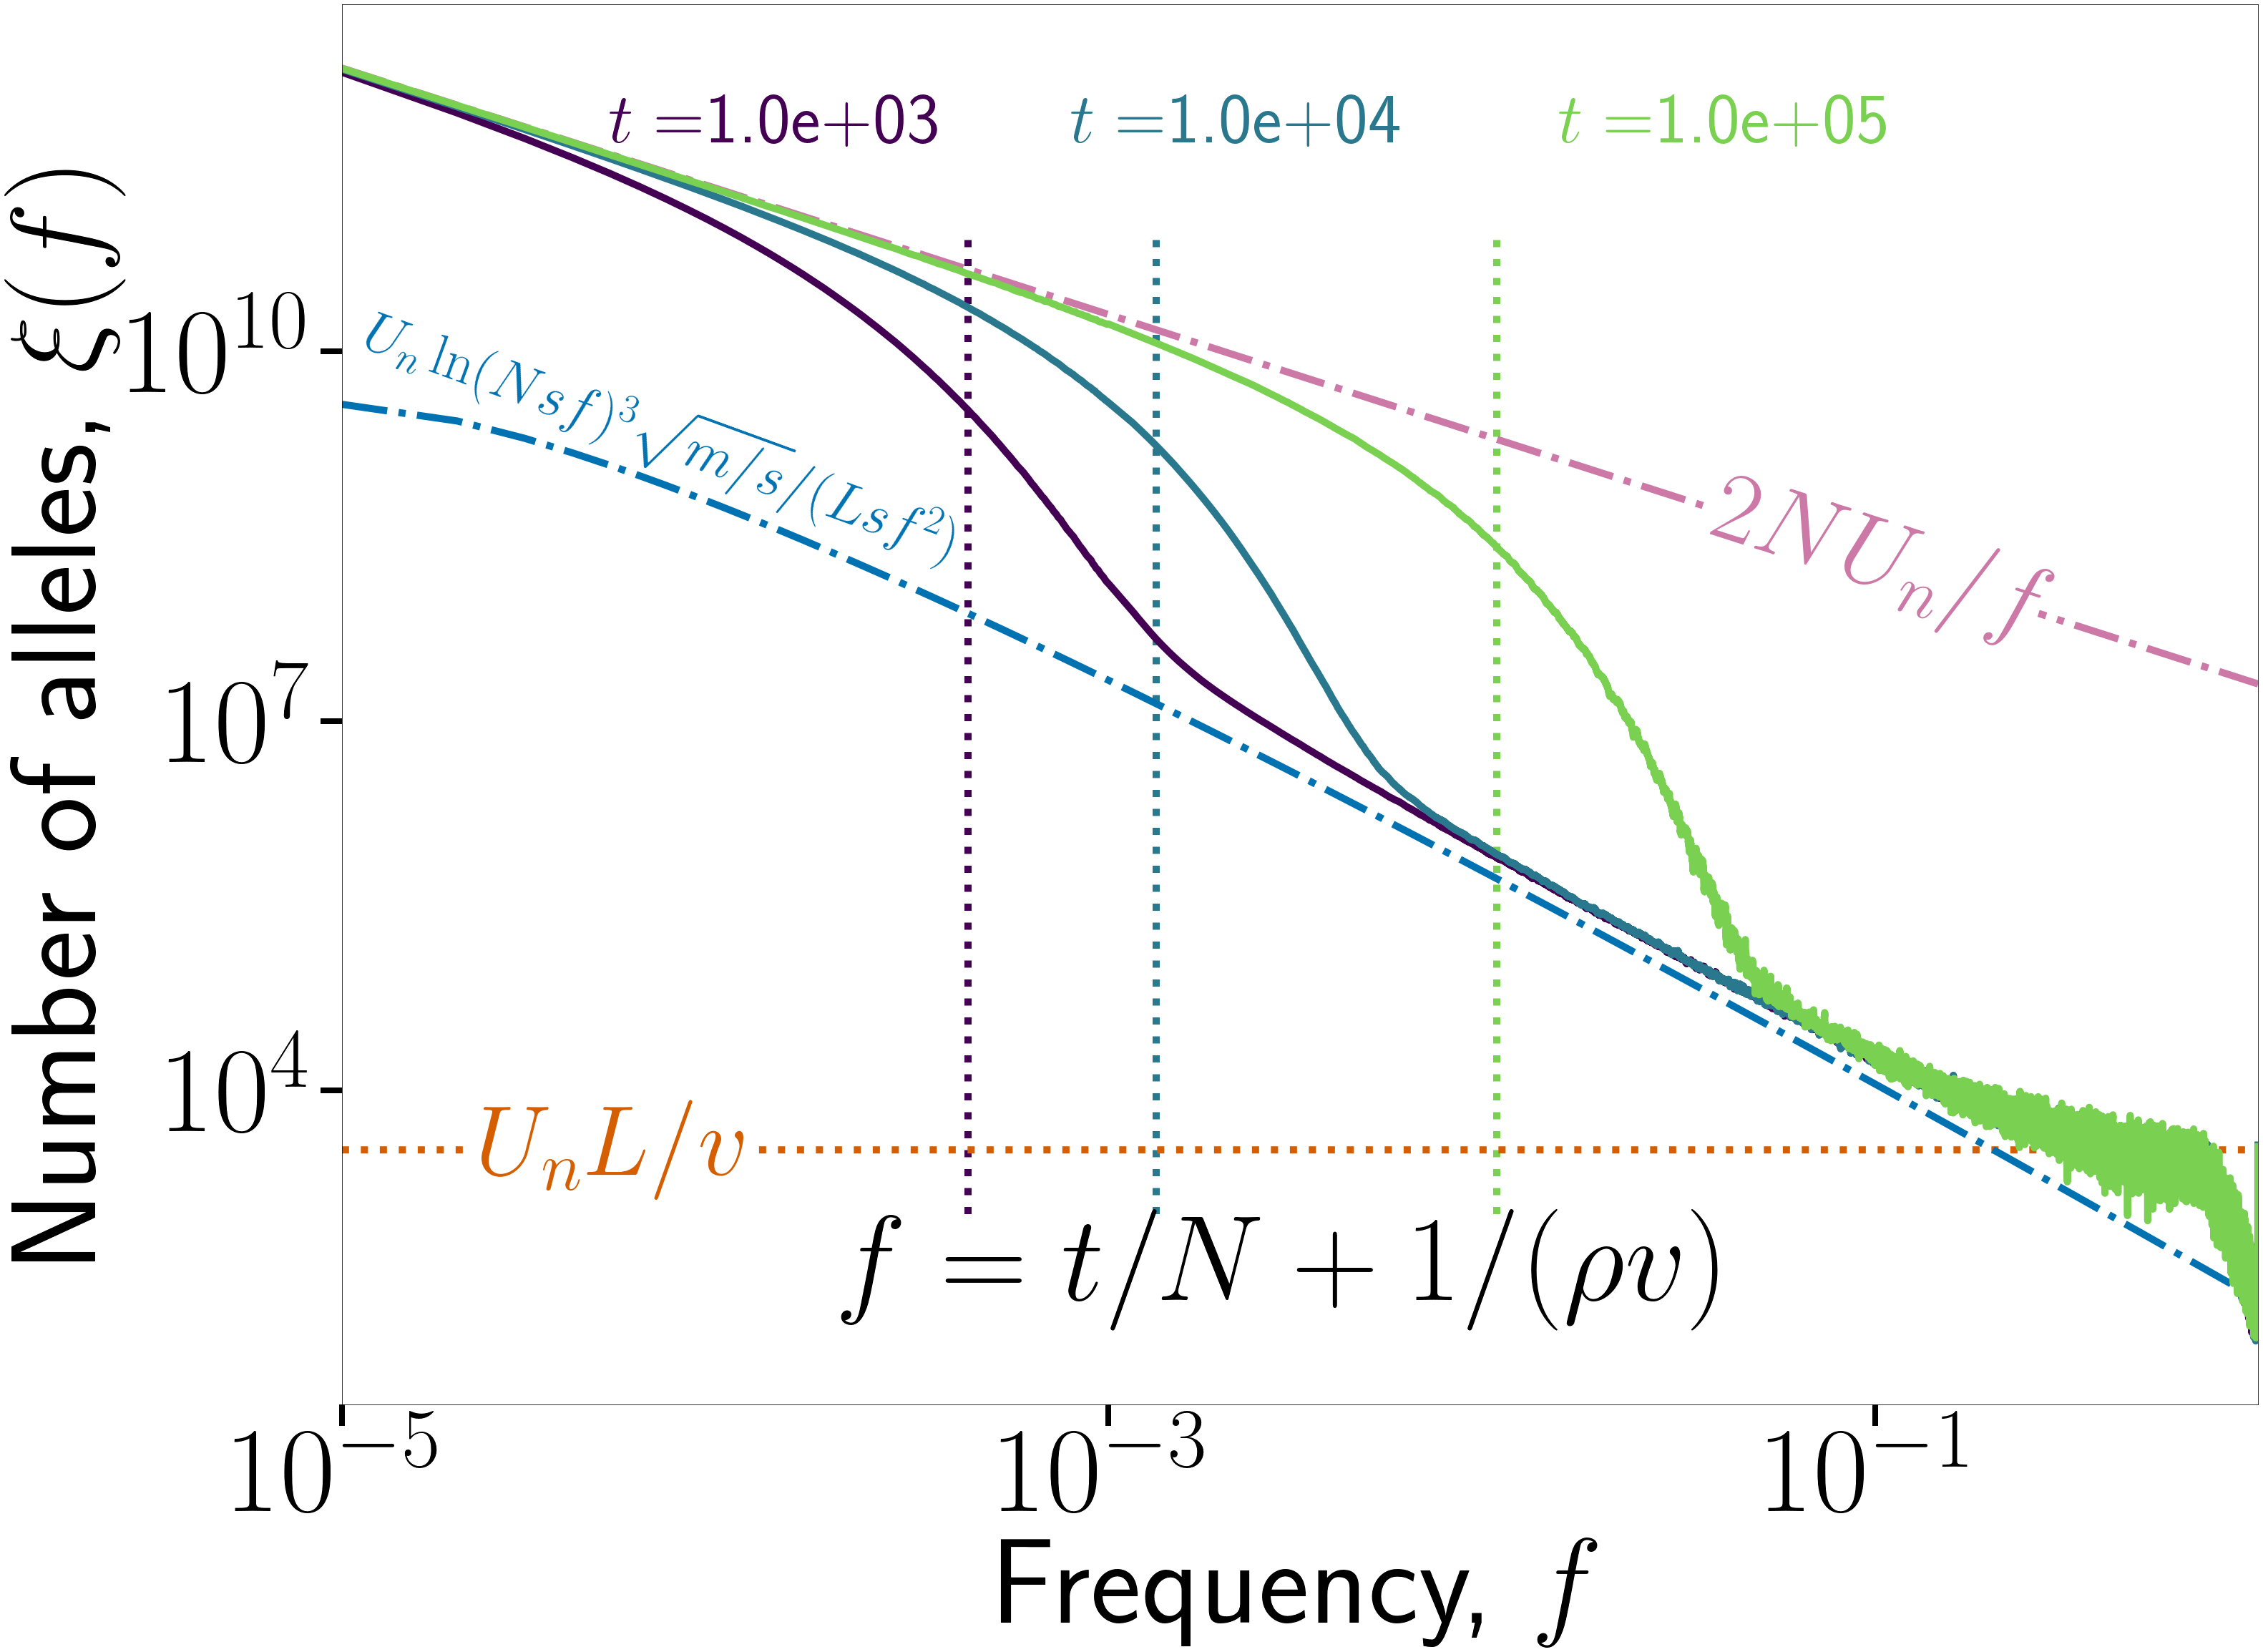

In [92]:
fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
tfix = 0


# Change m - sample everywhere
n = 100000
nSFS = 1000

tfixlist = [1000, 10000, 100000]
viridis_cmap = cm.get_cmap('viridis')

fitlist = []

f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)


freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(
           L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)
#xpositions = [6 * 10 ** (-5), 10 ** (-3), 10 ** (-2)]
xpositions = [5 * 10 ** (-5), 8 * 10 ** (-4), 1.5 * 10 ** (-2)]

ax.text(2 * 10 ** -4, 200, r'$f = t / N + 1 / (\rho v)$')
flat, = ax.loglog(f_short, np.ones(len(f_short)) * L / v, linewidth = 10, 
           linestyle = 'dotted'
              , label = r'$ U_n L / v$', color = '#d55e00')
neutral, = ax.loglog(f_short, 
           2 * Un * N * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '-.',
           linewidth = 10, color = '#cc79a7')
bsc, = ax.loglog(f_short, 
           Un * np.sqrt(m / s) / (L * s * f_short ** 2) * np.log(N * s * f_short) ** 3, 
           # label = r'$U_n \ln(Nsf)^3 \sqrt{m/s} / (L s f^2)$', 
           linestyle = '-.', linewidth = 10, color = '#0072b2')
ax.text(1.1e-5, 2e8, r'$U_n \ln(Nsf)^3 \sqrt{m/s} / (L s f^2)$', color = '#0072b2', fontsize=80, rotation=-20)

xvals = [5 * 10 ** (-5), 0.1, 0.5 * 10 ** (-4)]
labelLines(plt.gca().get_lines(), xvals = xvals, backgroundcolor = 'w', fontsize = 140)

for tind in range(len(tfixlist)):
    tfix = tfixlist[tind]
    # Find v from lines
    SFS = np.loadtxt(
        'backward_simulation_data/SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    ax.loglog(f_short, 
                 moving_average(SFS, navg, start_smooth), 
                 linewidth = 10, 
                 color = viridis_cmap(tind * 0.4), 
                 label = '$t =${:.2e}'.format(tfix))
    
    ax.vlines(tfix / N + 1 / (v * rho), 10 ** 3, 10 ** 11, linestyle = 'dotted',
               linewidth = 10, color = viridis_cmap(tind * 0.4))
    ax.text(xpositions[tind], 5 * 10 ** 11, 
             r'$t = $' + '{:.1e}'.format(tfix), 
             color = viridis_cmap(tind * 0.4), fontsize = 100)    
    popt, pcov = curve_fit(power_law_fit, f[fit_range_ind], SFS[fit_range_ind])
    fitlist.append(popt[0])


ax.set_xlim((1e-5, 1))


In [93]:
# save figure:
fig.savefig('uniform_tail.pdf', format = 'pdf', bbox_inches = 'tight')

## SFS of sexual population (compare 1D and well-mixed with the same $r, s$)

In [94]:
rho = 5000
L = 2000
N = rho * L
m = 0.25

n_forward = 100
T_after_fix = 0
tfinal = 100000

s = 0.05
n = 10000
n_sim_well_mixed = 10000


In [95]:
def logit(x):
    return np.log(x / (1 - x))

In [96]:

freq_file = open(
       'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)
    
v = np.average(v_list)


In [97]:
#1) large r where neutral diversity is recovered for both well-mixed and 1D

r = 0.01
nback_sim_1d = 1000

# Load the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [98]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


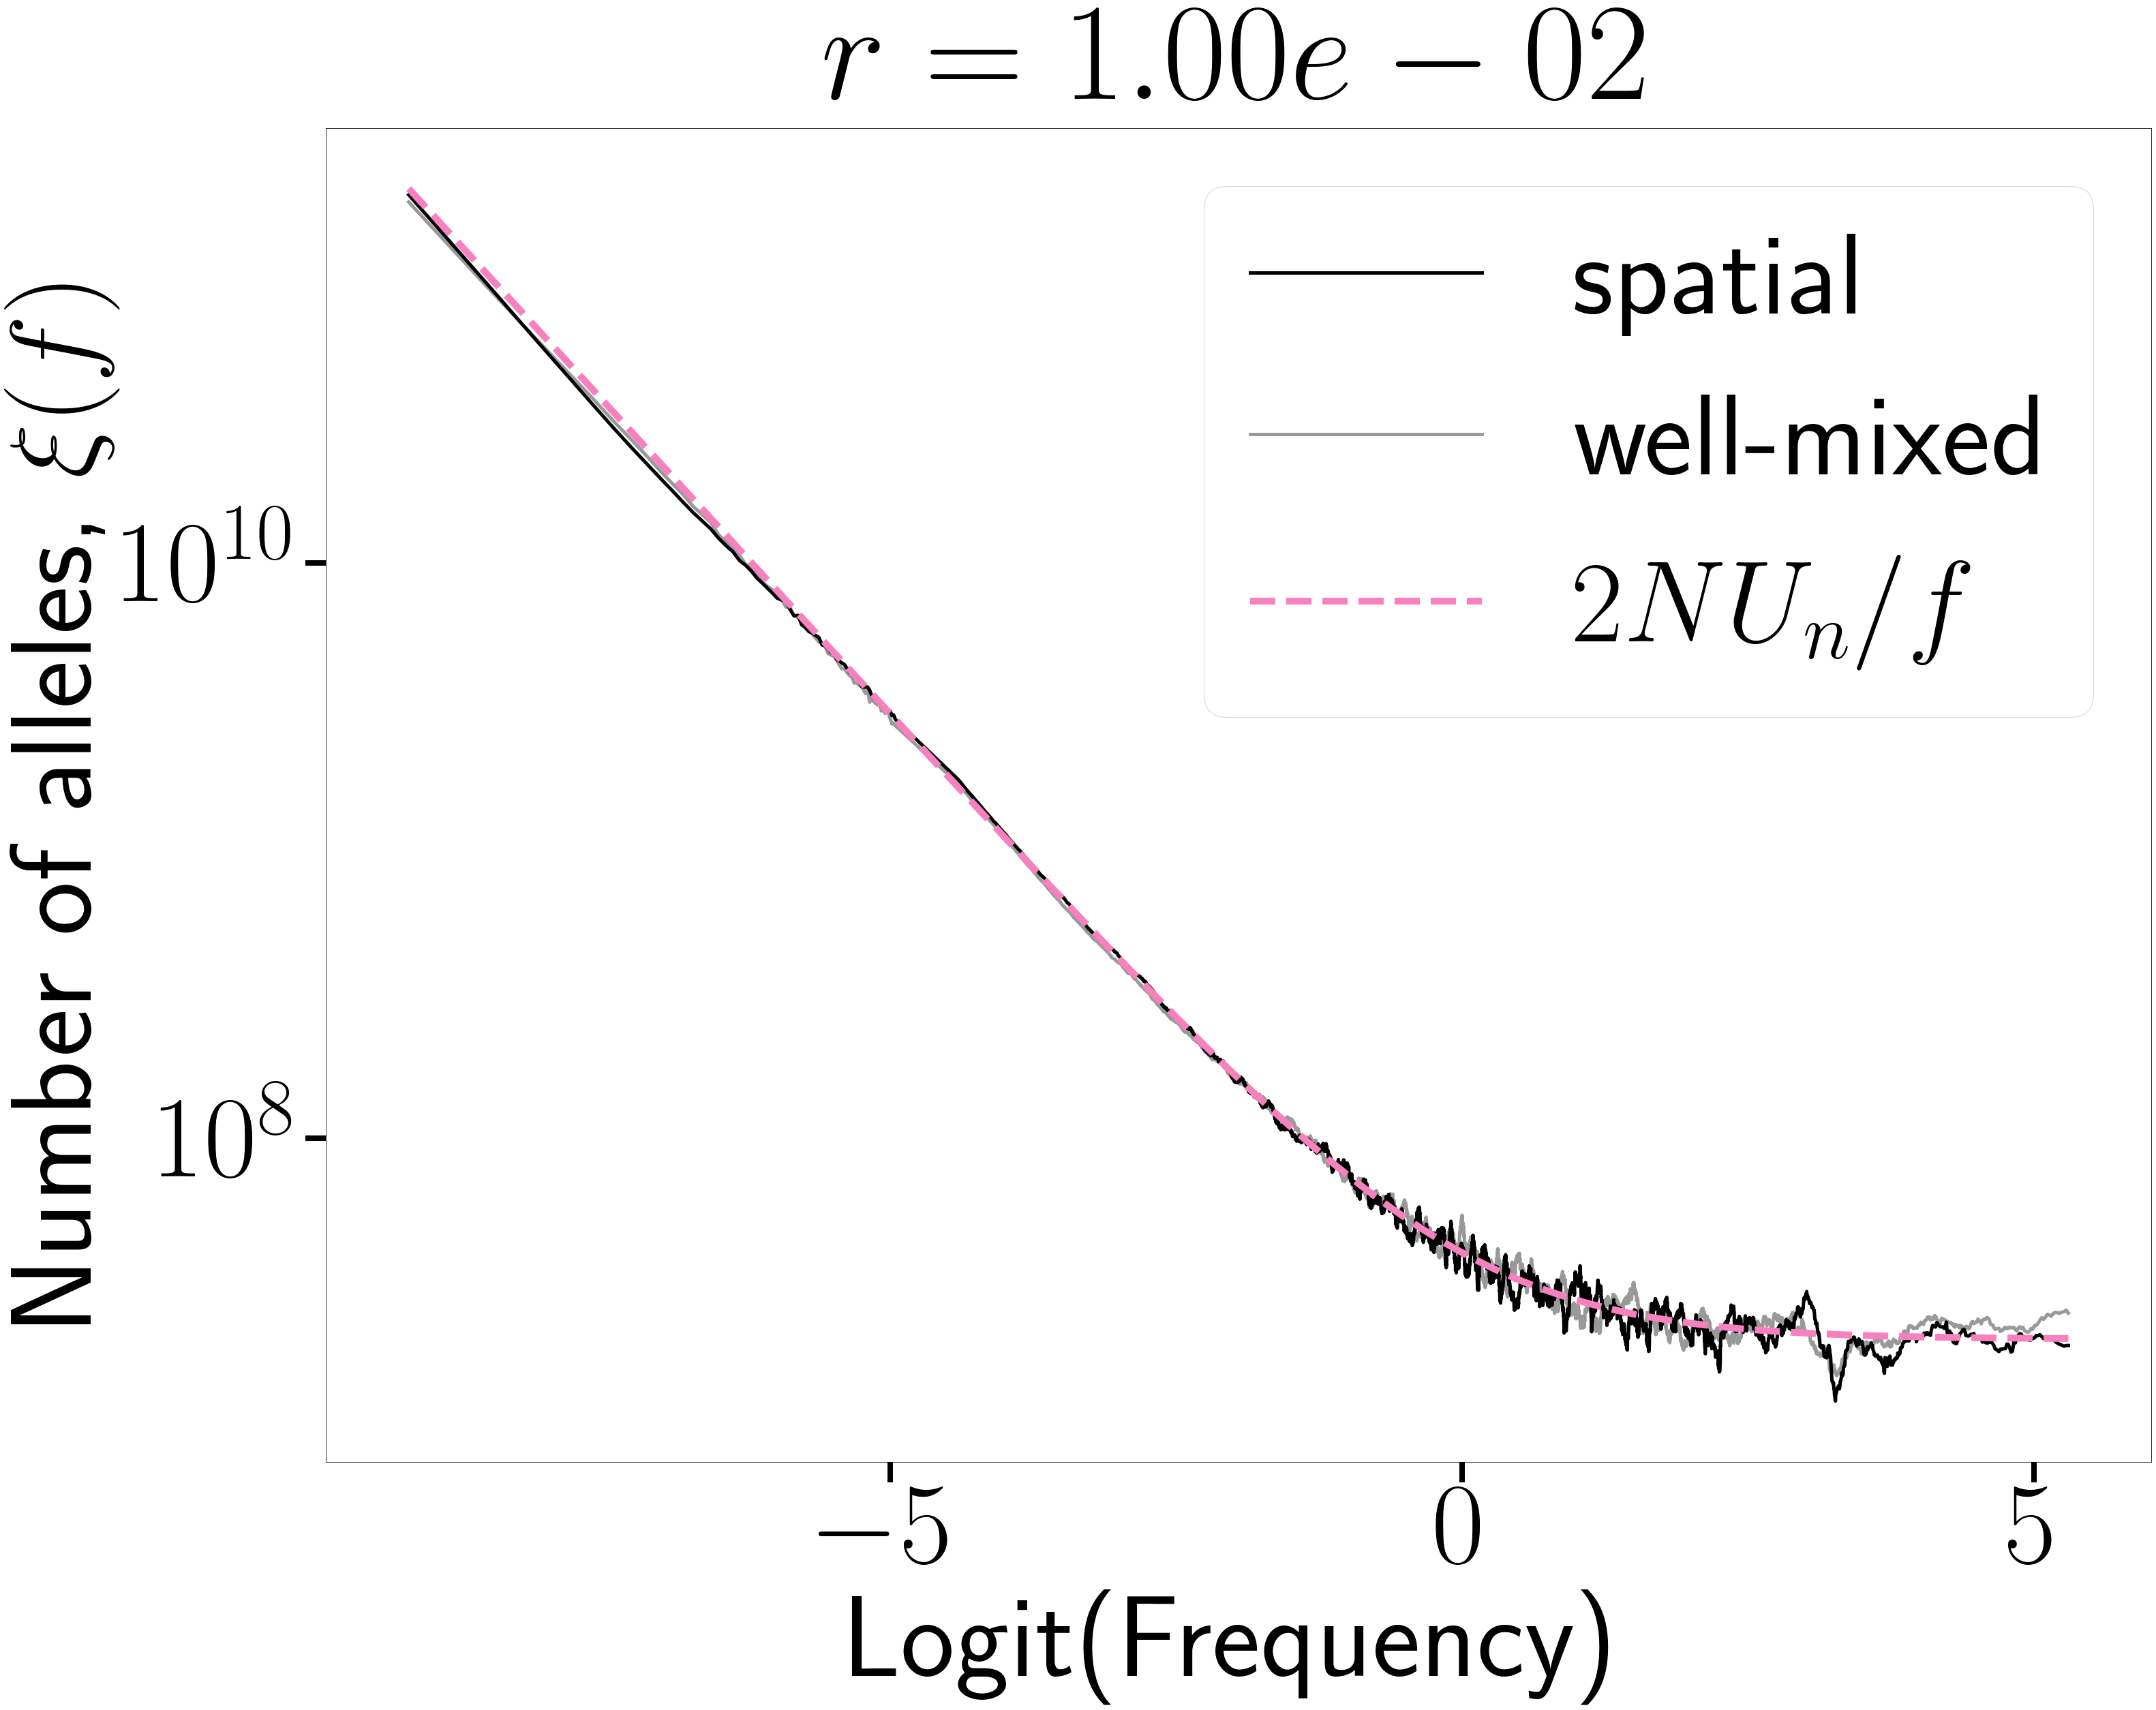

In [99]:
# Plot SFSs (1D and well-mixed) and neutral asymptote

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel('Logit(Frequency)')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r = {:.2e}$'.format(r))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), linewidth = 5, 
        label = 'spatial'.format(r), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_1d, smooth_start_1d), 
            linewidth = 5, alpha = 0.4, color = 'k', label = 'well-mixed')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linewidth = 10, linestyle = '--', label = r'$2 N U_n / f$', 
                 color = '#f781bf')
ax.legend()

In [100]:
fig.savefig('sex_high.pdf', format = 'pdf', bbox_inches = 'tight')

In [101]:
# 2) v / L << r << lambda << s

r = 5 * 10 ** -4
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [102]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)


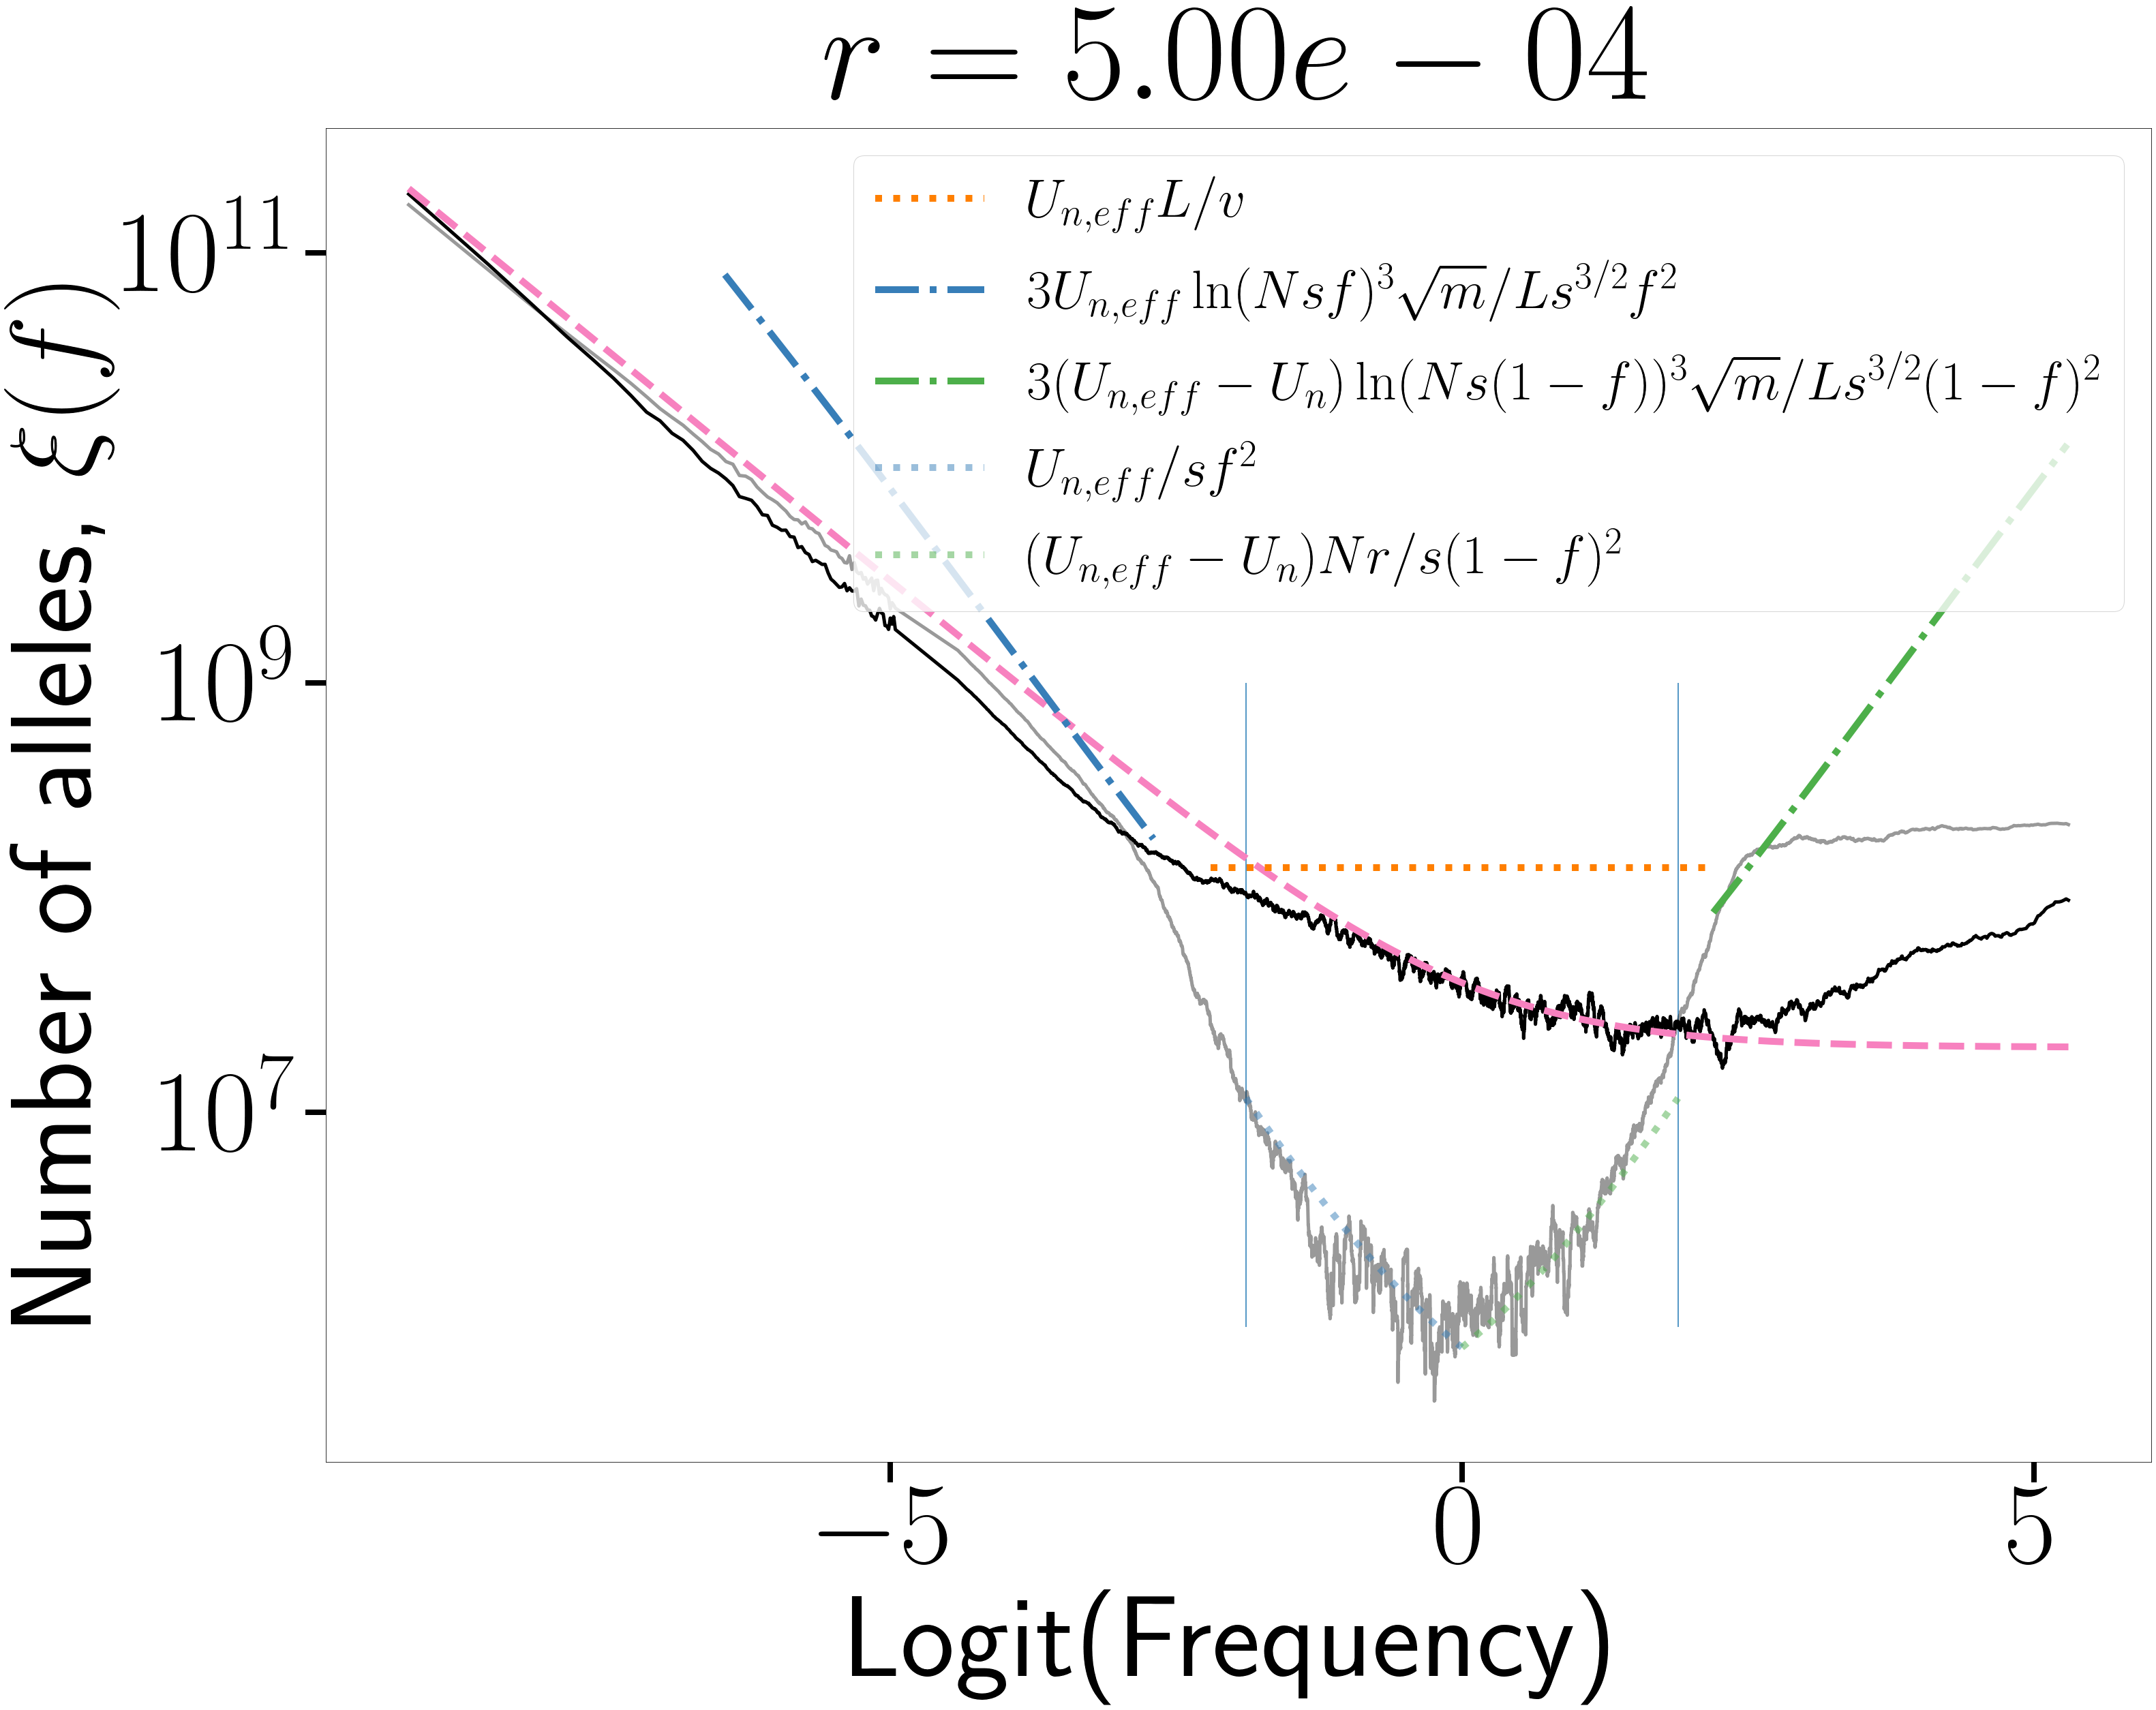

In [103]:
# Plot SFSs (1D and well-mixed), neutral asymptote, and non-neutral asymptotes

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel('Logit(Frequency)')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r = {:.2e}$'.format(r))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), linewidth = 5, color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_1d, smooth_start_1d), 
            linewidth = 5, alpha = 0.4, color = 'k')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linewidth = 10, linestyle = '--', 
                 color = '#f781bf')

ax.semilogy(logit(f_uniform), 
                      (1 + 2 * N * r) * L / v * np.ones(len(f_uniform)), 
                  linewidth = 10, linestyle = 'dotted', 
                  label = r'$U_{n, eff} L / v$', 
                  color = '#ff7f00')
ax.semilogy(logit(f_BSC_left), 
                  3 * (1 + 2 * N * r) * np.log(N * s * f_BSC_left) ** 3 * np.sqrt(m / s) / L / s / f_BSC_left ** 2, 
                  linewidth = 10, linestyle = '-.', 
                  label = r'$3U_{n, eff} \ln(Nsf)^3 \sqrt{m} / L s^{3/2} f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right), 
                  3 * (2 * N * r) * np.log(N * s * (1 - f_BSC_right)) ** 3 * np.sqrt(m / s) / L / s / (1 - f_BSC_right) ** 2, 
                  linewidth = 10, linestyle = '-.', 
                  color ='#4daf4a', 
                  label = r'$3(U_{n, eff} - U_n) \ln(Ns(1 - f))^3 \sqrt{m} / L s^{3/2} (1 - f)^2$')

ax.semilogy(logit(f_BSC_left_wellmixed), 
                  (1 + 2 * N * r) / s / f_BSC_left_wellmixed ** 2, 
                  linewidth = 10, alpha = 0.5, linestyle = 'dotted', 
                  label = r'$U_{n, eff} / s f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right_wellmixed), 
                  (2 * N * r) / s / (1 - f_BSC_right_wellmixed) ** 2, 
                  linewidth = 10, linestyle = 'dotted', alpha = 0.5, 
                  color ='#4daf4a', 
                  label = r'$(U_{n, eff} - U_n) N r / s (1 - f)^2$')

ax.vlines(logit(np.log(N * s) * r / s), 10 ** 6, 10 ** 9)
ax.vlines(-logit(np.log(N * s) * r / s), 10 ** 6, 10 ** 9)


ax.legend(fontsize = 80)

In [34]:
fig.savefig('sex_middle.pdf', format = 'pdf', bbox_inches = 'tight')

In [35]:
# 3)  r << v / L << lambda << s

r = 10 ** -4
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [36]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)

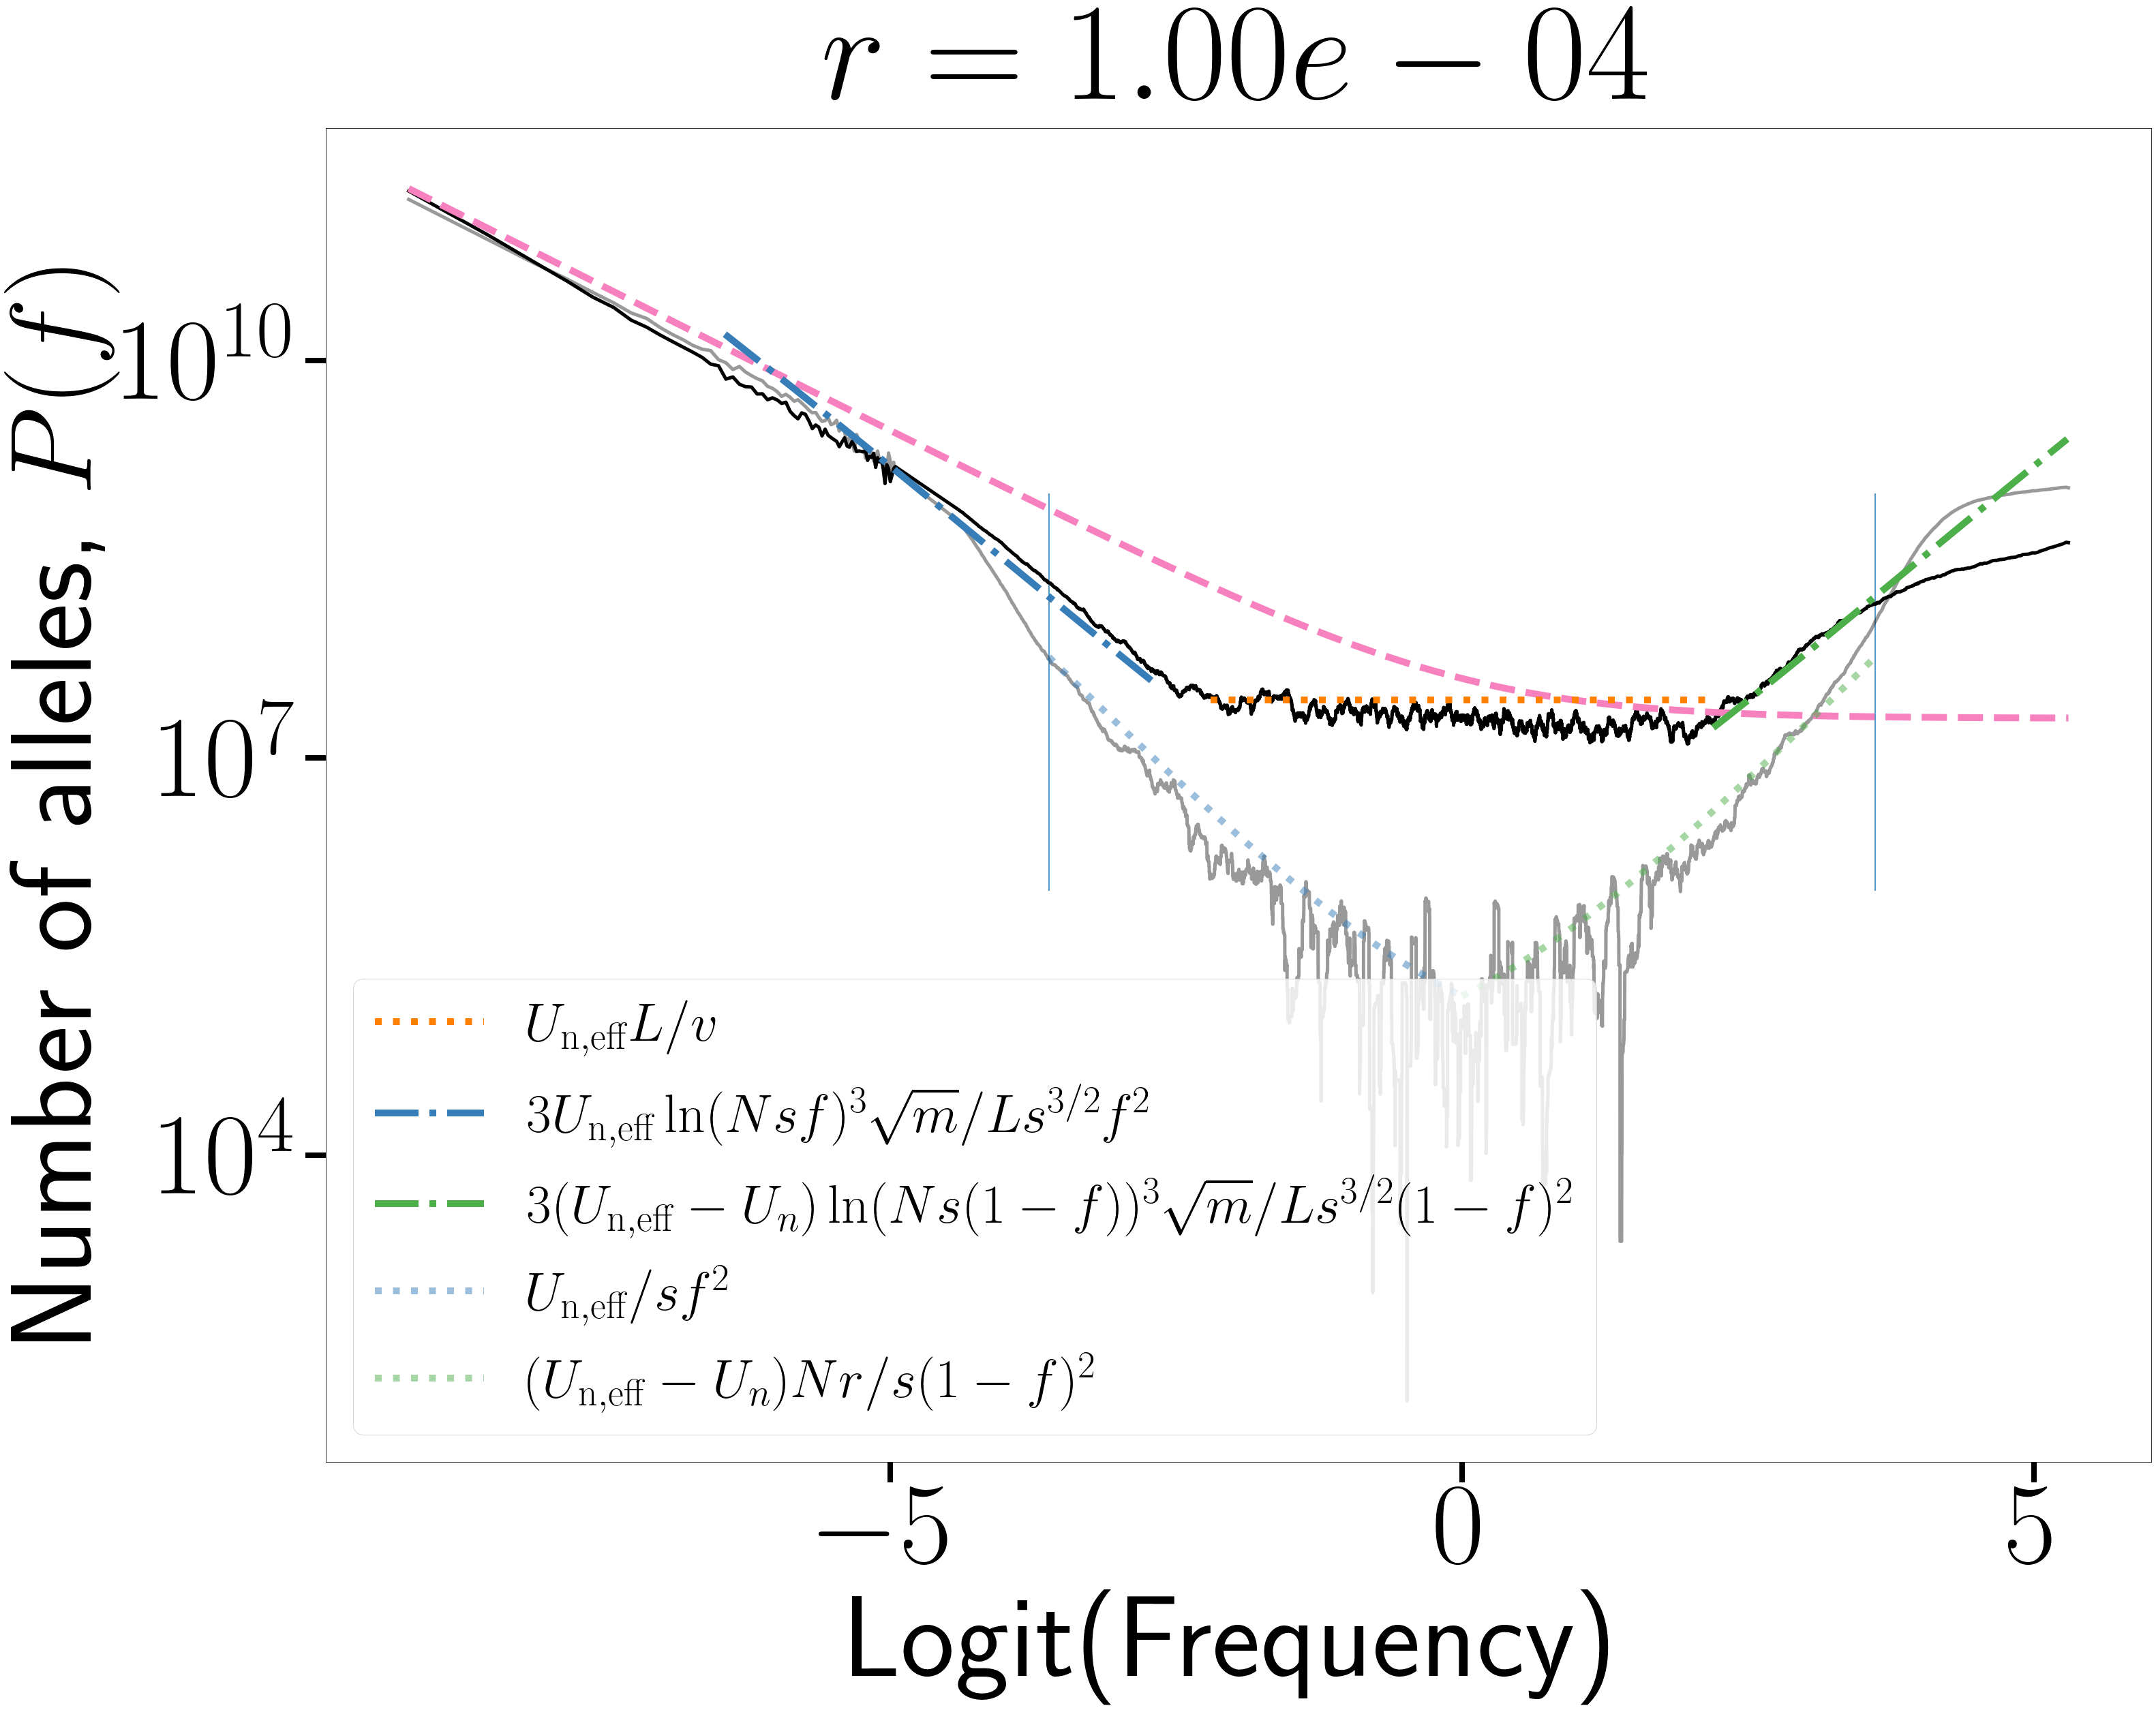

In [37]:
# Plot SFSs (1D and well-mixed), neutral asymptote, and non-neutral asymptotes

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel('Logit(Frequency)')
ax.set_ylabel(r'Number of alleles, $P(f)$')
ax.set_title(r'$r = {:.2e}$'.format(r))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), linewidth = 5, color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_1d, smooth_start_1d), 
            linewidth = 5, alpha = 0.4, color = 'k')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linewidth = 10, linestyle = '--', 
                 color = '#f781bf')

ax.semilogy(logit(f_uniform), 
                      (1 + 2 * N * r) * L / v * np.ones(len(f_uniform)), 
                  linewidth = 10, linestyle = 'dotted', 
                  label = r'$U_\mathrm{n, eff} L / v$', 
                  color = '#ff7f00')
ax.semilogy(logit(f_BSC_left), 
                  3 * (1 + 2 * N * r) * np.log(N * s * f_BSC_left) ** 3 * np.sqrt(m / s) / L / s / f_BSC_left ** 2, 
                  linewidth = 10, linestyle = '-.', 
                  label = r'$3U_\mathrm{n, eff} \ln(Nsf)^3 \sqrt{m} / L s^{3/2} f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right), 
                  3 * (2 * N * r) * np.log(N * s * (1 - f_BSC_right)) ** 3 * np.sqrt(m / s) / L / s / (1 - f_BSC_right) ** 2, 
                  linewidth = 10, linestyle = '-.', 
                  color ='#4daf4a', 
                  label = r'$3(U_\mathrm{n, eff} - U_n) \ln(Ns(1 - f))^3 \sqrt{m} / L s^{3/2} (1 - f)^2$')

ax.semilogy(logit(f_BSC_left_wellmixed), 
                  (1 + 2 * N * r) / s / f_BSC_left_wellmixed ** 2, 
                  linewidth = 10, alpha = 0.5, linestyle = 'dotted', 
                  label = r'$U_\mathrm{n, eff} / s f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right_wellmixed), 
                  (2 * N * r) / s / (1 - f_BSC_right_wellmixed) ** 2, 
                  linewidth = 10, linestyle = 'dotted', alpha = 0.5, 
                  color ='#4daf4a', 
                  label = r'$(U_\mathrm{n, eff} - U_n) N r / s (1 - f)^2$')

ax.vlines(logit(np.log(N * s) * r / s), 10 ** 6, 10 ** 9)
ax.vlines(-logit(np.log(N * s) * r / s), 10 ** 6, 10 ** 9)


ax.legend(fontsize = 80, loc = 'lower left')

In [38]:
fig.savefig('sex_low.pdf', format = 'pdf', bbox_inches = 'tight')

In [39]:
# 3)  r << v / L << lambda < s

r = 5 * 10 ** -3
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [40]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)

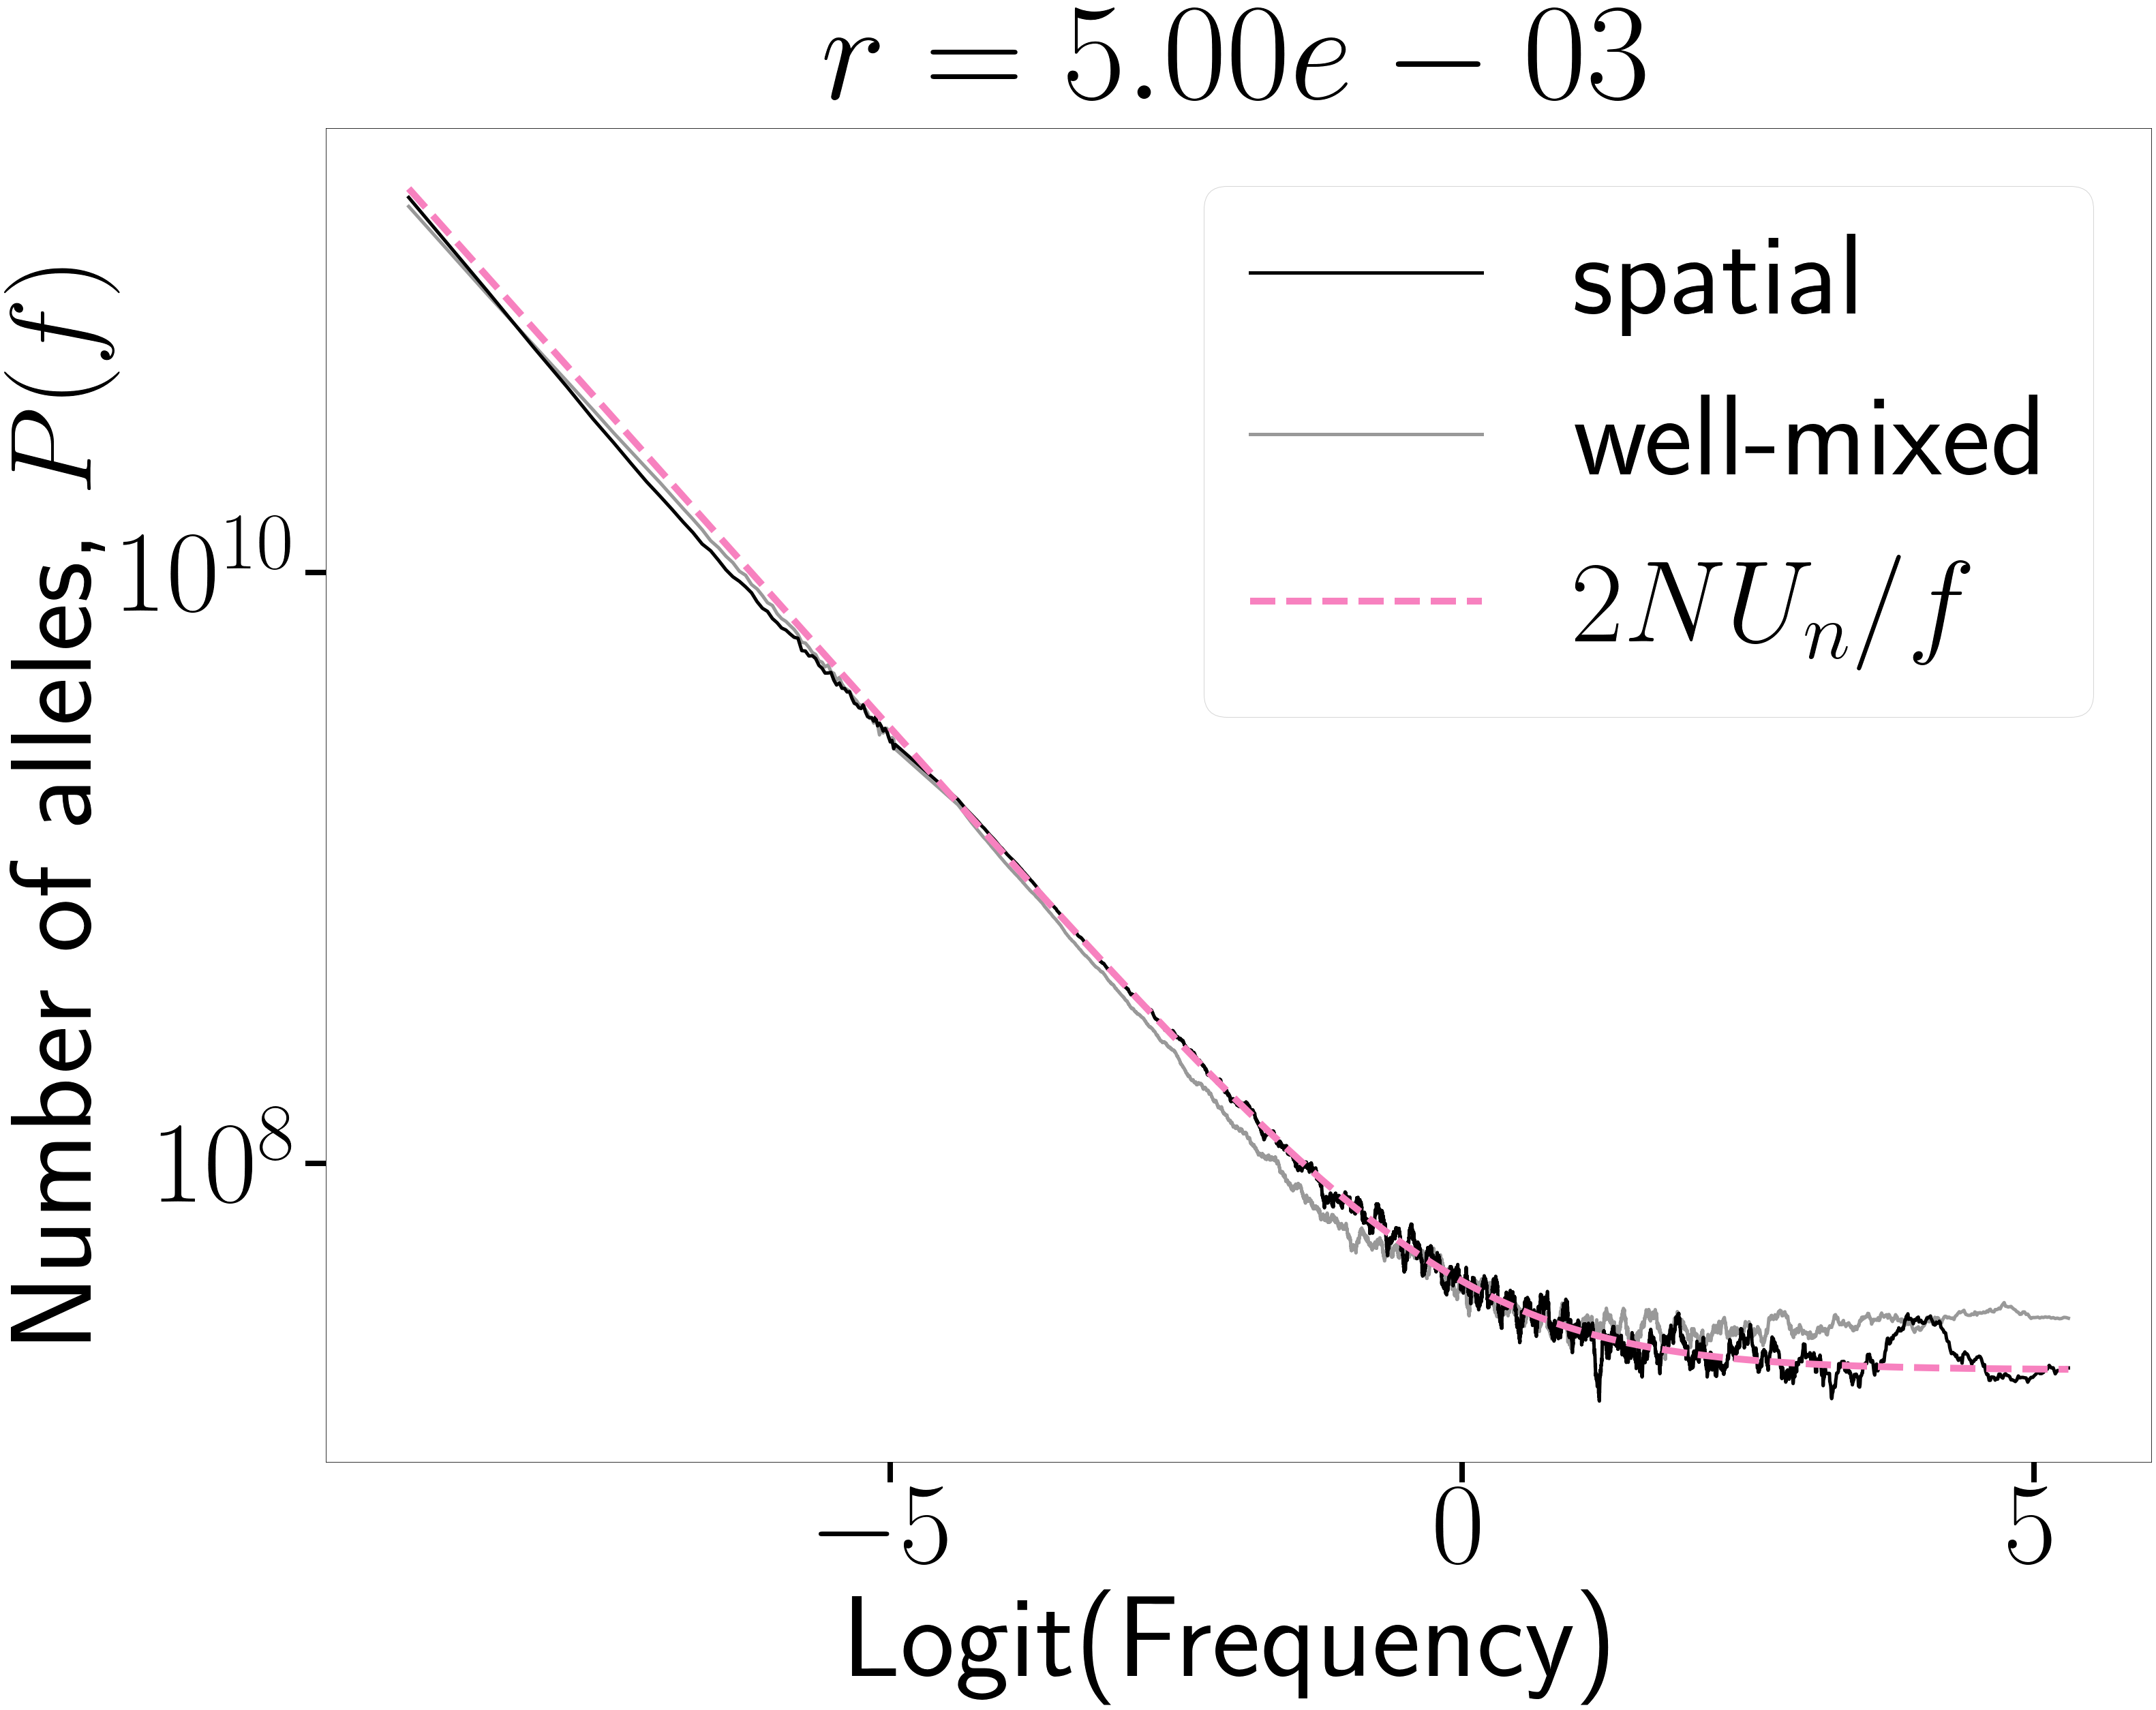

In [42]:
# Plot SFSs (1D and well-mixed) and neutral asymptote

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel('Logit(Frequency)')
ax.set_ylabel(r'Number of alleles, $P(f)$')
ax.set_title(r'$r = {:.2e}$'.format(r))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), linewidth = 5, 
        label = 'spatial'.format(r), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_1d, smooth_start_1d), 
            linewidth = 5, alpha = 0.4, color = 'k', label = 'well-mixed')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linewidth = 10, linestyle = '--', label = r'$2 N U_n / f$', 
                 color = '#f781bf')
ax.legend()